In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sazzatbhai/control_signal/alpha.pkl
/kaggle/input/sazzatbhai/control_signal/target_velocity.pkl
/kaggle/input/sazzatbhai/control_signal/target_angle.pkl
/kaggle/input/sazzatbhai/control_signal/omega.pkl
/kaggle/input/sazzatbhai/control_signal/torque.pkl
/kaggle/input/sazzatbhai/control_signal/theta.pkl
/kaggle/input/sazzatbhai/control_signal/time.pkl


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

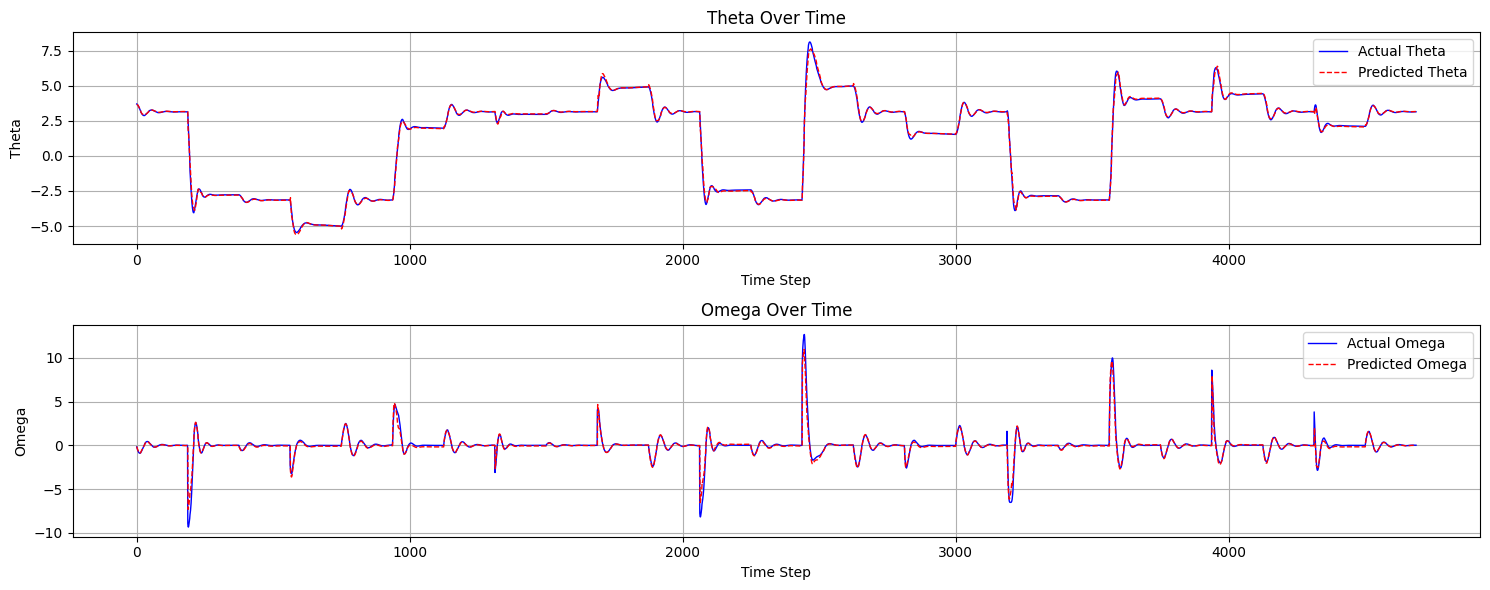

In [3]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import pickle
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from torchdyn.models import NeuralODE
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import torchdyn.core  
#load data
def load_data(theta_file_path, omega_file_path, torque_file_path):
    with open(theta_file_path, 'rb') as f:
        theta = pickle.load(f)
    with open(omega_file_path, 'rb') as f:
        omega = pickle.load(f)
    with open(torque_file_path, 'rb') as f:
        torque = pickle.load(f)
    return theta, omega, torque

# prepare dataset
def prepare_continuous_dataset(theta, omega, torque, train_size=12000, val_size=3000):
    # Converting data to PyTorch tensors
    theta_tensor = torch.tensor(theta, dtype=torch.float32)
    omega_tensor = torch.tensor(omega, dtype=torch.float32)
    torque_tensor = torch.tensor(torque, dtype=torch.float32)

    # Combining theta and omega into one tensor
    inputs = torch.stack((theta_tensor[:-1], omega_tensor[:-1]), dim=1)
    control_inputs = torque_tensor[:-1]

    # Targets are the next state of theta and omega
    targets = torch.stack((theta_tensor[1:], omega_tensor[1:]), dim=1)

    # Spliting the dataset into training, validation, and test sets
    train_inputs = inputs[:train_size]
    train_controls = control_inputs[:train_size]
    train_targets = targets[:train_size]

    val_inputs = inputs[train_size:train_size + val_size]
    val_controls = control_inputs[train_size:train_size + val_size]
    val_targets = targets[train_size:train_size + val_size]

    test_inputs = inputs[train_size + val_size:]
    test_controls = control_inputs[train_size + val_size:]
    test_targets = targets[train_size + val_size:]

    # creating dataLoader for the training, validation, and test sets
    train_loader = DataLoader(TensorDataset(train_inputs, train_controls, train_targets), batch_size=16, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_inputs, val_controls, val_targets), batch_size=16, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_inputs, test_controls, test_targets), batch_size=16, shuffle=False)

    return train_loader, val_loader, test_loader
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        # Define the network layers
        self.network = nn.Sequential(
            nn.Linear(3, 64),  # Input layer (2 state variables + 1 control input)
            nn.Tanh(), 
            nn.Linear(64, 128),
            nn.Tanh(),  
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 2)   # Output layer (next state prediction)
        )
    
    def forward(self, x):
        # Forward pass through the network
        return self.network(x)
class PendulumMLPPL(pl.LightningModule):
    def __init__(self):
        super(PendulumMLPPL, self).__init__()
        self.model = MLPModel()  # Initialize the MLP model
    
    def forward(self, x_control):
        # Forward pass, where x_control includes both state and control
        return self.model(x_control)
    
    def training_step(self, batch, batch_idx):
        x, control, y = batch
        # Concatenate state and control inputs
        x_control = torch.cat([x, control.unsqueeze(-1)], dim=1)
        # Predict the next state
        y_hat = self(x_control)  # Correctly pass concatenated input
        # Calculate loss (Mean Squared Error)
        loss = nn.MSELoss()(y_hat, y)
        # Logging
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, control, y = batch
        x_control = torch.cat([x, control.unsqueeze(-1)], dim=1)
        y_hat = self(x_control)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    
    def configure_optimizers(self):
        # Optimizer
        return torch.optim.Adam(self.parameters(), lr=0.001)



# path directory of Data
file_path = '/kaggle/input/sazzatbhai/control_signal/'
theta_file_path = file_path + 'theta.pkl'
omega_file_path = file_path + 'omega.pkl'
torque_file_path = file_path + 'torque.pkl'

# loading the data
theta, omega, torque = load_data(theta_file_path, omega_file_path, torque_file_path)

# preparing dataset
train_loader, val_loader, test_loader = prepare_continuous_dataset(theta, omega, torque)

# Early Stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=3,
    verbose=True,
    mode='min'
)
# Instantiate the MLP model for training
model =PendulumMLPPL()

# Training
trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[early_stop_callback],
    num_sanity_val_steps=0
)
trainer.fit(model, train_loader, val_loader)
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_predictions_for_test_set_new(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode
    predicted_states = []  # Accumulate predictions
    actual_states = []  # Accumulate actual states

    with torch.no_grad():
        for inputs, control, targets in test_loader:
            num_steps = inputs.size(0)  # Number of time steps in the current batch

            for i in range(num_steps - 1):
                current_state = inputs[i].unsqueeze(0)  # Current state
                current_control = control[i].unsqueeze(0).unsqueeze(-1)  # Correctly reshape control input
                # Concatenate state and control inputs
                x_control = torch.cat([current_state, current_control], dim=1)
                
                next_state = model(x_control).detach()  # Predict the next state
                predicted_states.append(next_state.squeeze().cpu().numpy())
                actual_states.append(targets[i].numpy())

    predicted_states = np.array(predicted_states)
    actual_states = np.array(actual_states)
    plt.figure(figsize=(15, 6))

    # Plot for Theta
    plt.subplot(2, 1, 1)
    plt.plot(actual_states[:, 0], 'b-', label='Actual Theta', linewidth=1)
    plt.plot(predicted_states[:, 0], 'r--', label='Predicted Theta', linewidth=1)
    plt.title('Theta Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Theta')
    plt.legend()
    plt.grid(True)

    # Plot for Omega
    plt.subplot(2, 1, 2)
    plt.plot(actual_states[:, 1], 'b-', label='Actual Omega', linewidth=1)
    plt.plot(predicted_states[:, 1], 'r--', label='Predicted Omega', linewidth=1)
    plt.title('Omega Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plotting code...

    model.train()  # Revert the model back to training mode
    
plot_predictions_for_test_set_new(model, test_loader)

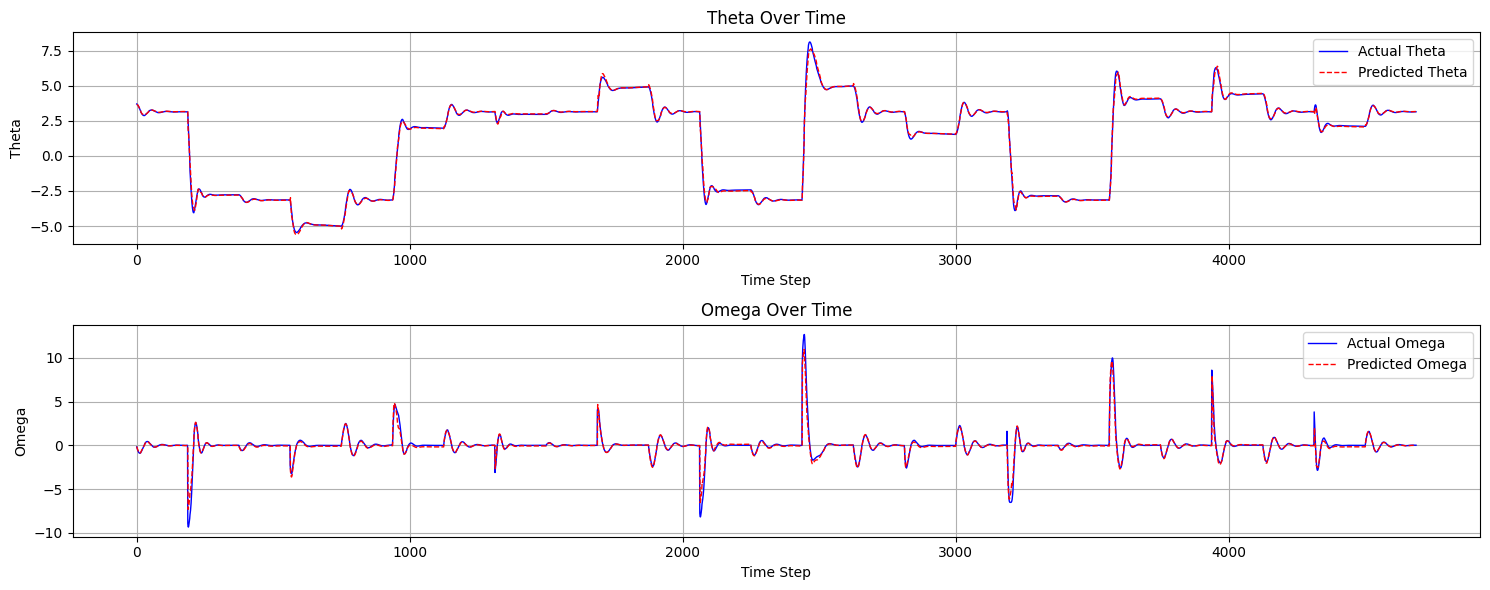

In [4]:
def plot_predictions_for_test_set_new(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode
    predicted_states = []  # Accumulate predictions
    actual_states = []  # Accumulate actual states

    with torch.no_grad():
        for inputs, control, targets in test_loader:
            num_steps = inputs.size(0)  # Number of time steps in the current batch

            for i in range(num_steps - 1):
                current_state = inputs[i].unsqueeze(0)  # Current state
                current_control = control[i].unsqueeze(0).unsqueeze(-1)  # Correctly reshape control input
                # Concatenate state and control inputs
                x_control = torch.cat([current_state, current_control], dim=1)
                
                next_state = model(x_control).detach()  # Predict the next state
                predicted_states.append(next_state.squeeze().cpu().numpy())
                actual_states.append(targets[i].numpy())

    predicted_states = np.array(predicted_states)
    actual_states = np.array(actual_states)
    plt.figure(figsize=(15, 6))

    # Plot for Theta
    plt.subplot(2, 1, 1)
    plt.plot(actual_states[:, 0], 'b-', label='Actual Theta', linewidth=1)
    plt.plot(predicted_states[:, 0], 'r--', label='Predicted Theta', linewidth=1)
    plt.title('Theta Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Theta')
    plt.legend()
    plt.grid(True)

    # Plot for Omega
    plt.subplot(2, 1, 2)
    plt.plot(actual_states[:, 1], 'b-', label='Actual Omega', linewidth=1)
    plt.plot(predicted_states[:, 1], 'r--', label='Predicted Omega', linewidth=1)
    plt.title('Omega Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plotting code...

    model.train()  # Revert the model back to training mode
    
plot_predictions_for_test_set_new(model, test_loader)

In [2]:
!pip install torchdyn

  Obtaining dependency information for torchdyn from https://files.pythonhosted.org/packages/a6/81/14535d528bf27cacb0fde2bb6893c9b852e17ae232f743cab99807f28ee4/torchdyn-1.0.6-py3-none-any.whl.metadata
  Obtaining dependency information for poethepoet<0.11.0,>=0.10.0 from https://files.pythonhosted.org/packages/b5/9e/13240bdacb9a2fdef104753febdd4c9ff1faf513641a5ee94bd8e2714e3c/poethepoet-0.10.0-py3-none-any.whl.metadata
  Obtaining dependency information for torchcde<0.3.0,>=0.2.3 from https://files.pythonhosted.org/packages/5b/86/f9aa5117cc932ddea16679b8cd8b4ff1ab48d5e9133a7e4c8f5111b90d63/torchcde-0.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for torchsde from https://files.pythonhosted.org/packages/dd/1f/b67ebd7e19ffe259f05d3cf4547326725c3113d640c277030be3e9998d6f/torchsde-0.2.6-py3-none-any.whl.metadata
  Obtaining dependency information for pastel<0.3.0,>=0.2.0 from https://files.pythonhosted.org/packages/aa/18/a8444036c6dd65ba3624c63b734d3ba95ba63ace513078e158

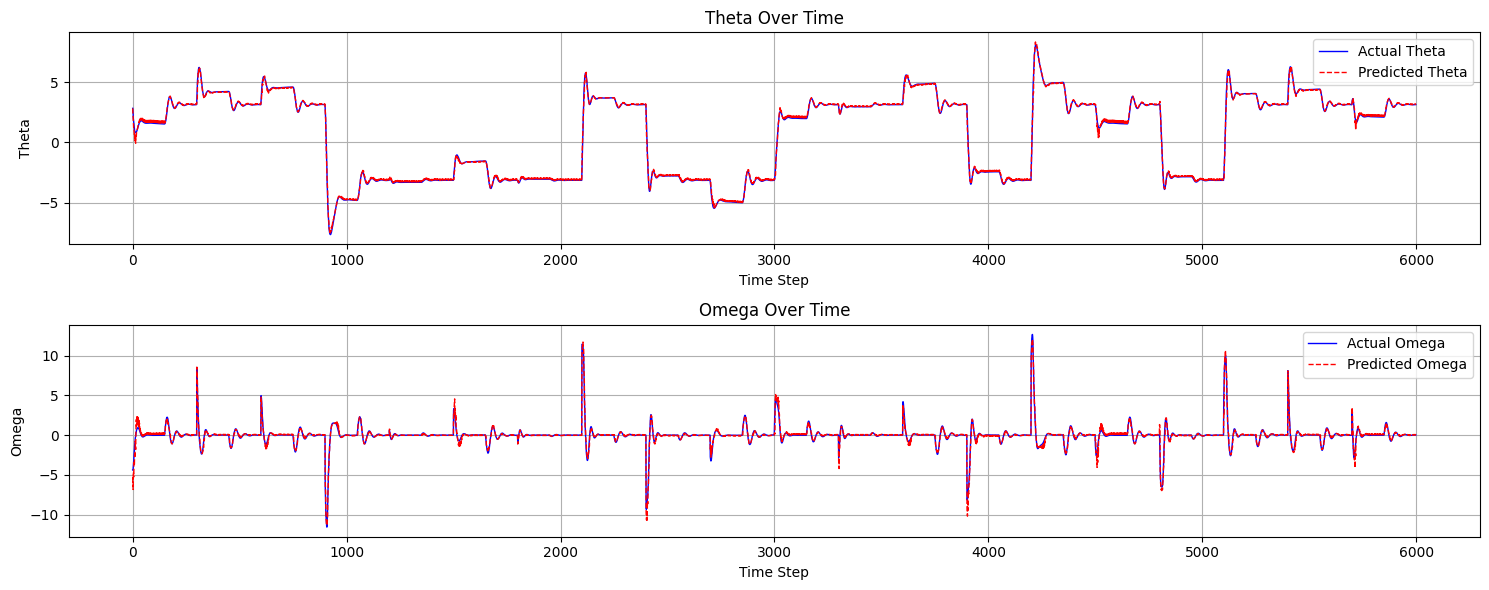

In [29]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Function to Plot Predictions for the Entire Test Set
def plot_predictions_for_test_set_new(model, test_loader):
    model.eval() # Ensure the model is in evaluation mode
    predicted_states = [] # Accumulate predictions
    actual_states = [] # Accumulate actual states

    with torch.no_grad():
        for inputs, control, targets in test_loader:
            num_steps = inputs.size(0) # Number of time steps in the current batch

            current_state = inputs[0]  # Initial state
            for i in range(num_steps - 1):
                next_state = model(current_state, control[i].unsqueeze(0)).detach()  # Assuming the model predicts the next state
                predicted_states.append(next_state.squeeze().cpu().numpy())
                actual_states.append(targets[i].numpy())
                current_state = next_state

    predicted_states = np.array(predicted_states)
    actual_states = np.array(actual_states)

    plt.figure(figsize=(15, 6))

    # Plot for Theta
    plt.subplot(2, 1, 1)
    plt.plot(actual_states[:, 0], 'b-', label='Actual Theta', linewidth=1)
    plt.plot(predicted_states[:, 0], 'r--', label='Predicted Theta', linewidth=1)
    plt.title('Theta Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Theta')
    plt.legend()
    plt.grid(True)

    # Plot for Omega
    plt.subplot(2, 1, 2)
    plt.plot(actual_states[:, 1], 'b-', label='Actual Omega', linewidth=1)
    plt.plot(predicted_states[:, 1], 'r--', label='Predicted Omega', linewidth=1)
    plt.title('Omega Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    model.train() # Revert the model back to training mode

# Assuming your new model is already trained and named new_model
plot_predictions_for_test_set_new(model, test_loader)


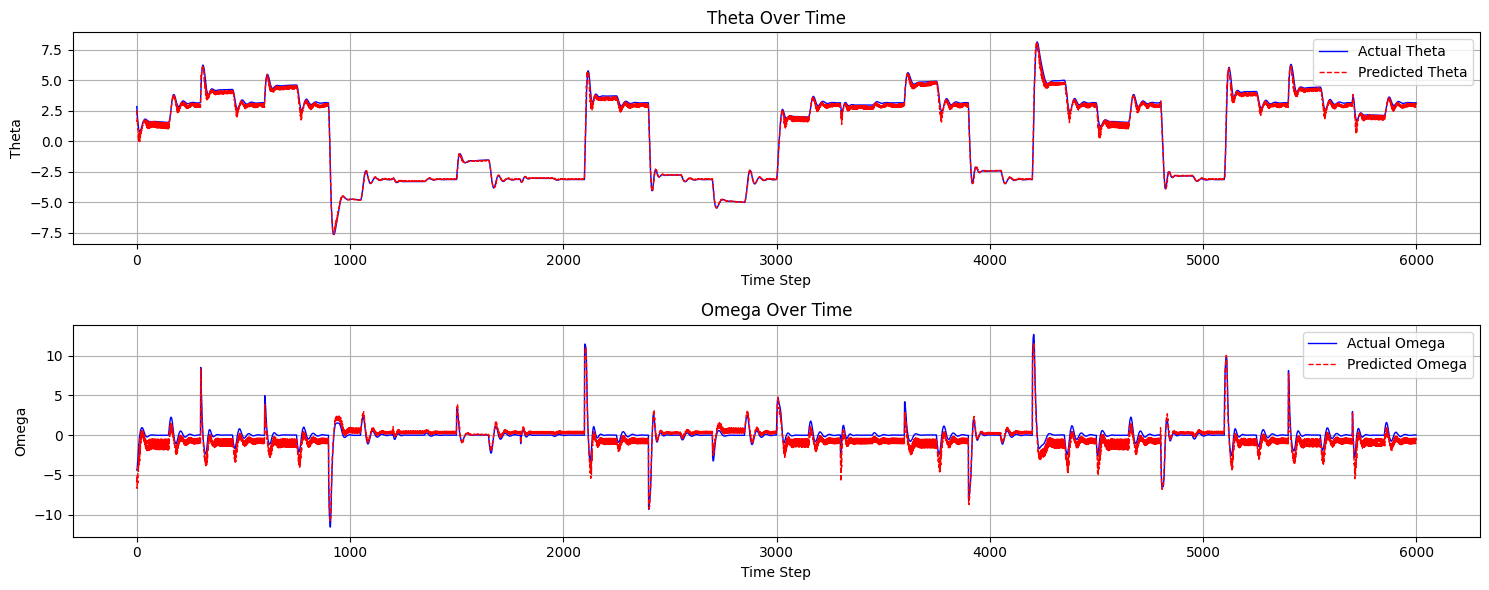

In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Function to Plot Predictions for the Entire Test Set
def plot_predictions_for_test_set_new(model, test_loader):
    model.eval() # Ensure the model is in evaluation mode
    predicted_states = [] # Accumulate predictions
    actual_states = [] # Accumulate actual states

    with torch.no_grad():
        for inputs, control, targets in test_loader:
            num_steps = inputs.size(0) # Number of time steps in the current batch

            current_state = inputs[0]  # Initial state
            for i in range(num_steps - 1):
                next_state = model(current_state, control[i].unsqueeze(0)).detach()  # Assuming the model predicts the next state
                predicted_states.append(next_state.squeeze().cpu().numpy())
                actual_states.append(targets[i].numpy())
                current_state = next_state

    predicted_states = np.array(predicted_states)
    actual_states = np.array(actual_states)

    plt.figure(figsize=(15, 6))

    # Plot for Theta
    plt.subplot(2, 1, 1)
    plt.plot(actual_states[:, 0], 'b-', label='Actual Theta', linewidth=1)
    plt.plot(predicted_states[:, 0], 'r--', label='Predicted Theta', linewidth=1)
    plt.title('Theta Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Theta')
    plt.legend()
    plt.grid(True)

    # Plot for Omega
    plt.subplot(2, 1, 2)
    plt.plot(actual_states[:, 1], 'b-', label='Actual Omega', linewidth=1)
    plt.plot(predicted_states[:, 1], 'r--', label='Predicted Omega', linewidth=1)
    plt.title('Omega Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    model.train() # Revert the model back to training mode

# Assuming your new model is already trained and named new_model
plot_predictions_for_test_set_new(model, test_loader)


In [49]:
import pickle
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from torchdyn.models import NeuralODE
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Function to load data
def load_data(theta_file_path, omega_file_path, torque_file_path):
    with open(theta_file_path, 'rb') as f:
        theta = pickle.load(f)
    with open(omega_file_path, 'rb') as f:
        omega = pickle.load(f)
    with open(torque_file_path, 'rb') as f:
        torque = pickle.load(f)
    return theta, omega, torque

# Function to prepare dataset
def prepare_continuous_dataset(theta, omega, torque, train_size=10000, val_size=2000):
    # Convert the data to PyTorch tensors
    theta_tensor = torch.tensor(theta, dtype=torch.float32)
    omega_tensor = torch.tensor(omega, dtype=torch.float32)
    torque_tensor = torch.tensor(torque, dtype=torch.float32)

    # Combine theta and omega into one tensor
    inputs = torch.stack((theta_tensor[:-1], omega_tensor[:-1]), dim=1)
    control_inputs = torque_tensor[:-1]

    # Targets will be the next state of theta and omega
    targets = torch.stack((theta_tensor[1:], omega_tensor[1:]), dim=1)

    # Split the dataset into training, validation, and test sets
    train_inputs = inputs[:train_size]
    train_controls = control_inputs[:train_size]
    train_targets = targets[:train_size]

    val_inputs = inputs[train_size:train_size + val_size]
    val_controls = control_inputs[train_size:train_size + val_size]
    val_targets = targets[train_size:train_size + val_size]

    test_inputs = inputs[train_size + val_size:]
    test_controls = control_inputs[train_size + val_size:]
    test_targets = targets[train_size + val_size:]

    # Create DataLoader instances for the training, validation, and test sets
    train_loader = DataLoader(TensorDataset(train_inputs, train_controls, train_targets), batch_size=16, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_inputs, val_controls, val_targets), batch_size=16, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_inputs, test_controls, test_targets), batch_size=4, shuffle=False)

    return train_loader, val_loader, test_loader

# Define the ODE function
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, x, **kwargs):
        return self.net(x)
class NeuralODE(nn.Module):
    def __init__(self, model):
        super(NeuralODE, self).__init__()
        self.model = model
        self.integration_time = torch.tensor([0, 1]).float()
        self.solver = solver

    def forward(self, x, control):
        
            return self.model(x, control=control, t=self.integration_time, method=self.solver)
import torchdyn.core  # Ensure to import the necessary torchdyn components

class PendulumModel(nn.Module):
    def __init__(self):
        super(PendulumModel, self).__init__()
        self.func = ODEFunc()
        # Update this line to include sensitivity and solver configurations
        self.neural_ode = torchdyn.core.NeuralODE(self.func, sensitivity='adjoint', solver='rk4', 
                                                  solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4)

    def forward(self, x, control):
        t_span = torch.linspace(0, 1, 2)
        return self.neural_ode.trajectory(x, t_span)[-1]



# Define the PyTorch Lightning module
class PendulumModelPL(pl.LightningModule):
    def __init__(self):
        super(PendulumModelPL, self).__init__()
        self.model = PendulumModel()

    def forward(self, inputs, control):  # Modify the forward method to accept an optional control argument
        
            return self.model(inputs, control)
       


    def training_step(self, batch, batch_idx):
        x, control, y = batch
        y_hat = self(x, control)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, control, y = batch
        y_hat = self(x, control)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def on_epoch_end(self):
        # Print training and validation loss at the end of each epoch
        train_loss = self.trainer.callback_metrics.get("train_loss")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        print(f'Epoch {self.current_epoch}: train_loss={train_loss}, val_loss={val_loss}')

# Data path directory
file_path = '/kaggle/input/sazzatbhai/control_signal/'
theta_file_path = file_path + 'theta.pkl'
omega_file_path = file_path + 'omega.pkl'
torque_file_path = file_path + 'torque.pkl'

# Load the data
theta, omega, torque = load_data(theta_file_path, omega_file_path, torque_file_path)

# Prepare the dataset
train_loader, val_loader, test_loader = prepare_continuous_dataset(theta, omega, torque)

# Incorporate Early Stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=3,
    verbose=True,
    mode='min'
)

# Training and Evaluation
model = PendulumModelPL()
trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[early_stop_callback],
    num_sanity_val_steps=0  # Set num_sanity_val_steps to 0 to avoid DataLoader warning
)
trainer.fit(model, train_loader, val_loader)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

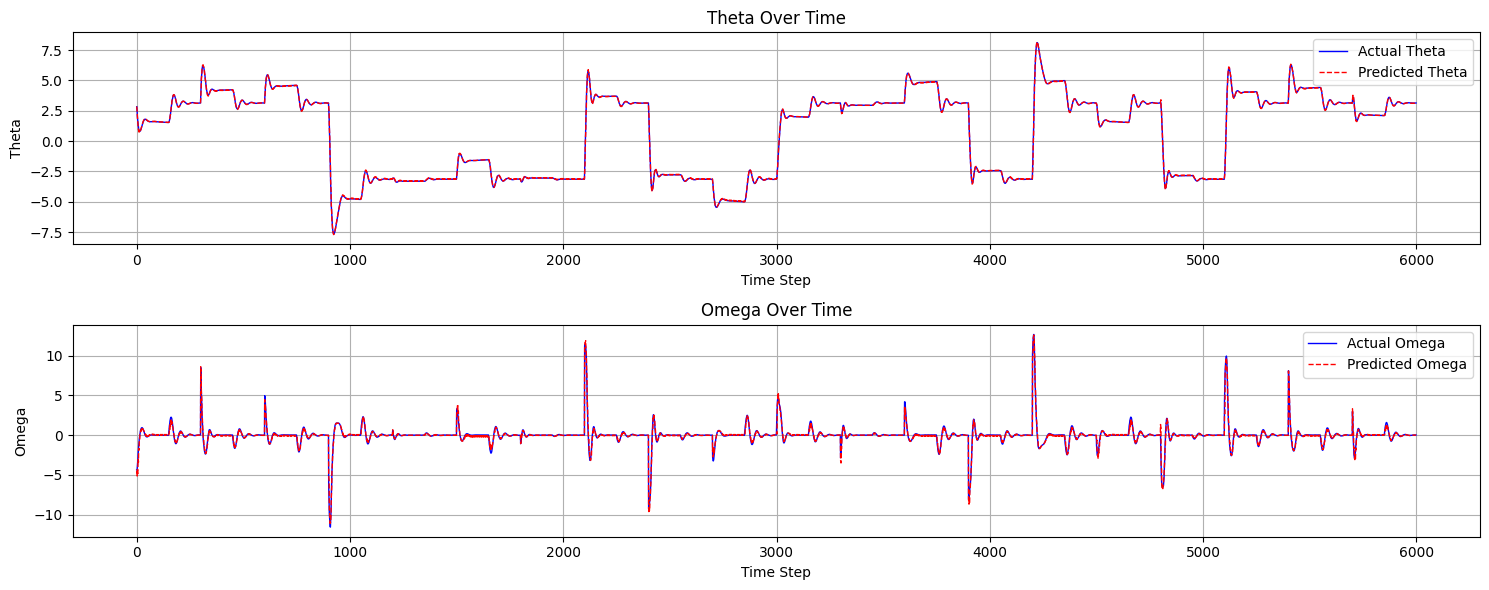

In [50]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Function to Plot Predictions for the Entire Test Set
def plot_predictions_for_test_set_new(model, test_loader):
    model.eval() # Ensure the model is in evaluation mode
    predicted_states = [] # Accumulate predictions
    actual_states = [] # Accumulate actual states

    with torch.no_grad():
        for inputs, control, targets in test_loader:
            num_steps = inputs.size(0) # Number of time steps in the current batch

            current_state = inputs[0]  # Initial state
            for i in range(num_steps - 1):
                next_state = model(current_state, control[i].unsqueeze(0)).detach()  # Assuming the model predicts the next state
                predicted_states.append(next_state.squeeze().cpu().numpy())
                actual_states.append(targets[i].numpy())
                current_state = next_state

    predicted_states = np.array(predicted_states)
    actual_states = np.array(actual_states)

    plt.figure(figsize=(15, 6))

    # Plot for Theta
    plt.subplot(2, 1, 1)
    plt.plot(actual_states[:, 0], 'b-', label='Actual Theta', linewidth=1)
    plt.plot(predicted_states[:, 0], 'r--', label='Predicted Theta', linewidth=1)
    plt.title('Theta Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Theta')
    plt.legend()
    plt.grid(True)

    # Plot for Omega
    plt.subplot(2, 1, 2)
    plt.plot(actual_states[:, 1], 'b-', label='Actual Omega', linewidth=1)
    plt.plot(predicted_states[:, 1], 'r--', label='Predicted Omega', linewidth=1)
    plt.title('Omega Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    model.train() # Revert the model back to training mode

# Assuming your new model is already trained and named new_model
plot_predictions_for_test_set_new(model, test_loader)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

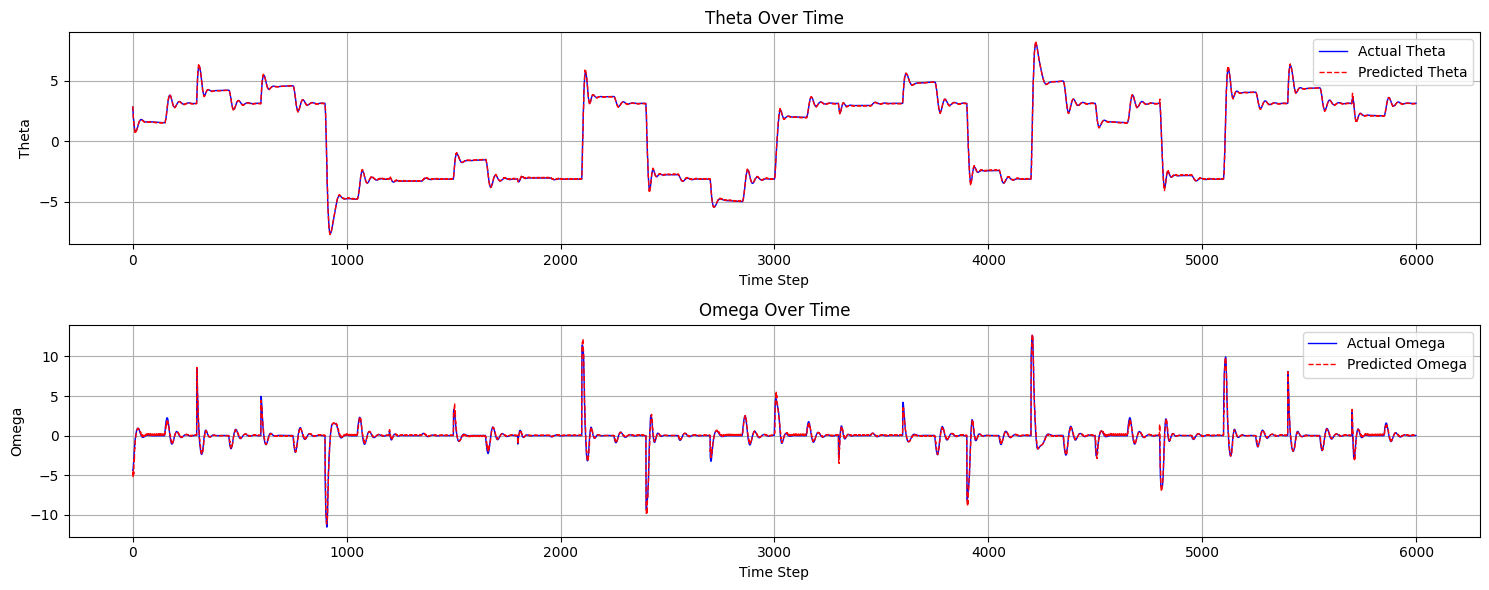

In [56]:
import pickle
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from torchdyn.models import NeuralODE
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import torchdyn.core  
#load data
def load_data(theta_file_path, omega_file_path, torque_file_path):
    with open(theta_file_path, 'rb') as f:
        theta = pickle.load(f)
    with open(omega_file_path, 'rb') as f:
        omega = pickle.load(f)
    with open(torque_file_path, 'rb') as f:
        torque = pickle.load(f)
    return theta, omega, torque

# prepare dataset
def prepare_continuous_dataset(theta, omega, torque, train_size=10000, val_size=2000):
    # Converting data to PyTorch tensors
    theta_tensor = torch.tensor(theta, dtype=torch.float32)
    omega_tensor = torch.tensor(omega, dtype=torch.float32)
    torque_tensor = torch.tensor(torque, dtype=torch.float32)

    # Combining theta and omega into one tensor
    inputs = torch.stack((theta_tensor[:-1], omega_tensor[:-1]), dim=1)
    control_inputs = torque_tensor[:-1]

    # Targets are the next state of theta and omega
    targets = torch.stack((theta_tensor[1:], omega_tensor[1:]), dim=1)

    # Spliting the dataset into training, validation, and test sets
    train_inputs = inputs[:train_size]
    train_controls = control_inputs[:train_size]
    train_targets = targets[:train_size]

    val_inputs = inputs[train_size:train_size + val_size]
    val_controls = control_inputs[train_size:train_size + val_size]
    val_targets = targets[train_size:train_size + val_size]

    test_inputs = inputs[train_size + val_size:]
    test_controls = control_inputs[train_size + val_size:]
    test_targets = targets[train_size + val_size:]

    # creating dataLoader for the training, validation, and test sets
    train_loader = DataLoader(TensorDataset(train_inputs, train_controls, train_targets), batch_size=16, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_inputs, val_controls, val_targets), batch_size=16, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_inputs, test_controls, test_targets), batch_size=4, shuffle=False)

    return train_loader, val_loader, test_loader

# Defining the ODE function
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, x, **kwargs):
        return self.net(x)
class NeuralODE(nn.Module):
    def __init__(self, model):
        super(NeuralODE, self).__init__()
        self.model = model
        self.integration_time = torch.tensor([0, 1]).float()
        self.solver = solver

    def forward(self, x, control):
        
            return self.model(x, control=control, t=self.integration_time, method=self.solver)


class PendulumModel(nn.Module):
    def __init__(self):
        super(PendulumModel, self).__init__()
        self.func = ODEFunc()
        # Update this line to include sensitivity and solver configurations
        self.neural_ode = torchdyn.core.NeuralODE(self.func, sensitivity='adjoint', solver='rk4', 
                                                  solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4)

    def forward(self, x, control):
        t_span = torch.linspace(0, 1, 2)
        return self.neural_ode.trajectory(x, t_span)[-1]



# Defining the PyTorch Lightning module
class PendulumModelPL(pl.LightningModule):
    def __init__(self):
        super(PendulumModelPL, self).__init__()
        self.model = PendulumModel()

    def forward(self, inputs, control):  # Modify the forward method to accept an optional control argument
        
            return self.model(inputs, control)
       


    def training_step(self, batch, batch_idx):
        x, control, y = batch
        y_hat = self(x, control)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, control, y = batch
        y_hat = self(x, control)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def on_epoch_end(self):
        # Print training and validation loss at the end of each epoch
        train_loss = self.trainer.callback_metrics.get("train_loss")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        print(f'Epoch {self.current_epoch}: train_loss={train_loss}, val_loss={val_loss}')

# path directory of Data
file_path = '/kaggle/input/sazzatbhai/control_signal/'
theta_file_path = file_path + 'theta.pkl'
omega_file_path = file_path + 'omega.pkl'
torque_file_path = file_path + 'torque.pkl'

# loading the data
theta, omega, torque = load_data(theta_file_path, omega_file_path, torque_file_path)

# preparing dataset
train_loader, val_loader, test_loader = prepare_continuous_dataset(theta, omega, torque)

# Early Stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=3,
    verbose=True,
    mode='min'
)

# Training and Evaluation
model = PendulumModelPL()
trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[early_stop_callback],
    num_sanity_val_steps=0  # Set num_sanity_val_steps to 0 to avoid DataLoader warning
)
trainer.fit(model, train_loader, val_loader)

import numpy as np
import torch
import matplotlib.pyplot as plt

# Function to Plot Predictions for the Entire Test Set
def plot_predictions_for_test_set_new(model, test_loader):
    model.eval() # Ensure the model is in evaluation mode
    predicted_states = [] # Accumulate predictions
    actual_states = [] # Accumulate actual states

    with torch.no_grad():
        for inputs, control, targets in test_loader:
            num_steps = inputs.size(0) # Number of time steps in the current batch

            current_state = inputs[0]  # Initial state
            for i in range(num_steps - 1):
                next_state = model(current_state, control[i].unsqueeze(0)).detach()  # Assuming the model predicts the next state
                predicted_states.append(next_state.squeeze().cpu().numpy())
                actual_states.append(targets[i].numpy())
                current_state = next_state

    predicted_states = np.array(predicted_states)
    actual_states = np.array(actual_states)

    plt.figure(figsize=(15, 6))

    # Plot for Theta
    plt.subplot(2, 1, 1)
    plt.plot(actual_states[:, 0], 'b-', label='Actual Theta', linewidth=1)
    plt.plot(predicted_states[:, 0], 'r--', label='Predicted Theta', linewidth=1)
    plt.title('Theta Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Theta')
    plt.legend()
    plt.grid(True)

    # Plot for Omega
    plt.subplot(2, 1, 2)
    plt.plot(actual_states[:, 1], 'b-', label='Actual Omega', linewidth=1)
    plt.plot(predicted_states[:, 1], 'r--', label='Predicted Omega', linewidth=1)
    plt.title('Omega Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    model.train() # Revert the model back to training mode

plot_predictions_for_test_set_new(model, test_loader)


In [55]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchdyn.core import NeuralODE
import pytorch_lightning as pl
from pytorch_lightning import Trainer

# Prepare the continuous dataset
theta, omega, torque = ..., ..., ...  # Replace with actual data
train_loader, val_loader, test_loader = prepare_continuous_dataset(theta, omega, torque)

# Define the MLP ODE function
class MLPODEFunc(nn.Module):
    def __init__(self):
        super(MLPOODEFunc, self).__init__()
        self.net = MLP(input_size=2, hidden_size=64, output_size=2, num_layers=3, activation='tanh')

    def forward(self, x, **kwargs):
        return self.net(x)

# Define the MLP NeuralODE model
class MLPNeuralODE(nn.Module):
    def __init__(self, model, solver='rk4'):
        super(MLPNueralODE, self).__init__()
        self.model = model
        self.integration_time = torch.tensor([0, 1]).float()
        self.solver = solver

    def forward(self, x, control):
        return self.model(x, control=control, t=self.integration_time, method=self.solver)

# Define the MLP Pendulum model
class MLPPendulumModel(nn.Module):
    def __init__(self):
        super(MLPPendulumModel, self).__init__()
        self.func = MLPODEFunc()
        self.neural_ode = MLPNeuralODE(self.func, solver='rk4')

    def forward(self, x, control):
        t_span = torch.linspace(0, 1, 2)
        return self.neural_ode.trajectory(x, t_span)[-1]

# Define the MLP Pendulum model for PyTorch Lightning
class MLPPendulumModelPL(pl.LightningModule):
    def __init__(self):
        super(MLPPendulumModelPL, self).__init__()
        self.model = MLPPendulumModel()

    def forward(self, inputs, control):
        return self.model(inputs, control)

    def training_step(self, batch, batch_idx):
        x, control, y = batch
        y_hat = self(x, control)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, control, y = batch
        y_hat = self(x, control)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def on_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        print(f'Epoch {self.current_epoch}: train_loss={train_loss}, val_loss={val_loss}')

# Train the MLP Pendulum model
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=3,
    verbose=True,
    mode='min'
)

model = MLPPendulumModelPL()
trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[early_stop_callback],
    num_sanity_val_steps=0  # Set num_sanity_val_steps to 0 to avoid DataLoader warning
)
trainer.fit(model, train_loader, val_loader)

TypeError: must be real number, not ellipsis

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

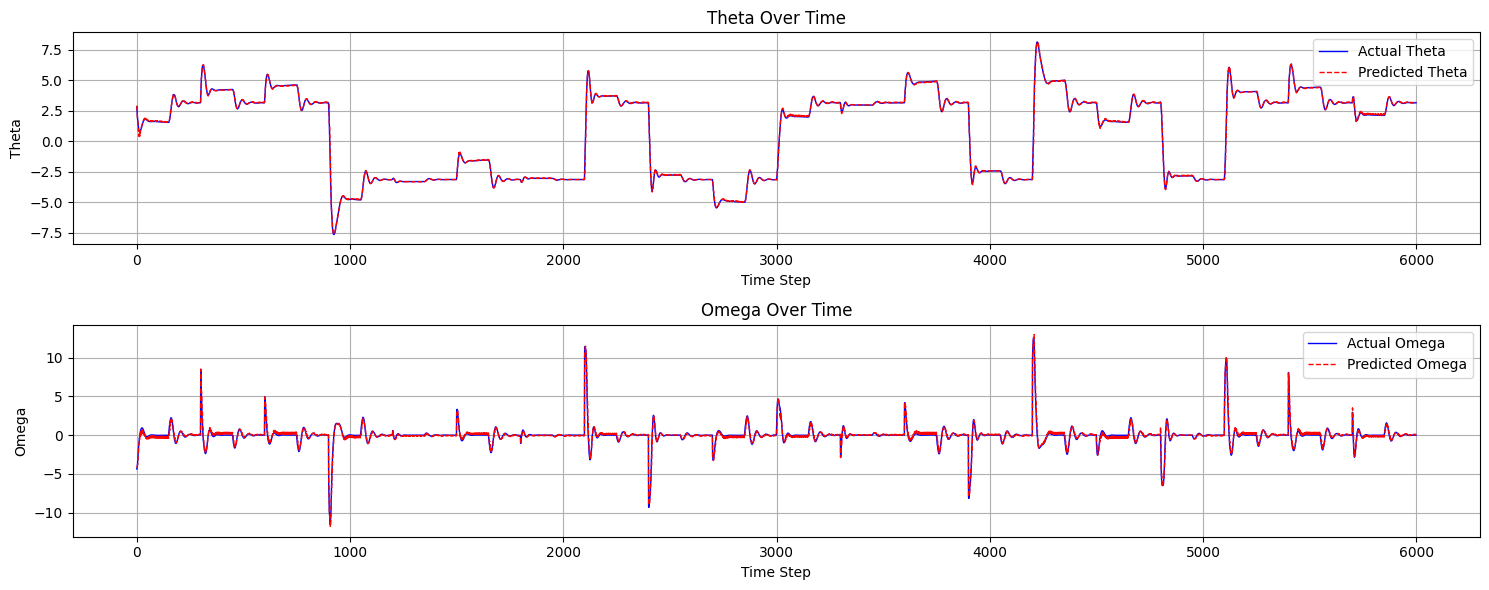

In [32]:
import pickle
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from torchdyn.models import NeuralODE
import matplotlib.pyplot as plt
import numpy as np


def load_data(theta_file_path, omega_file_path, torque_file_path):
  with open(theta_file_path, 'rb') as f:
    theta = pickle.load(f)
  with open(omega_file_path, 'rb') as f:
    omega = pickle.load(f)
  with open(torque_file_path, 'rb') as f:
    torque = pickle.load(f)
  return theta, omega, torque

def prepare_continuous_dataset(theta, omega, torque, train_size=10000, val_size=2000):

  # Convert the data to PyTorch tensors
  theta_tensor = torch.tensor(theta, dtype=torch.float32)
  omega_tensor = torch.tensor(omega, dtype=torch.float32)
  torque_tensor = torch.tensor(torque, dtype=torch.float32)

  # Stack the theta, omega, and torque tensors to create the input tensor
  inputs = torch.stack((theta_tensor[:-1], omega_tensor[:-1], torque_tensor[:-1]), dim=1)
  targets = torch.stack((theta_tensor[1:], omega_tensor[1:], torque_tensor[1:]), dim=1)

  # Split the dataset into training, validation, and test sets
  train_inputs = inputs[:train_size]
  train_targets = targets[:train_size]

  val_inputs = inputs[train_size:train_size + val_size]
  val_targets = targets[train_size:train_size + val_size]

  test_inputs = inputs[train_size + val_size:]
  test_targets = targets[train_size + val_size:]

  # Create DataLoader instances for the training, validation, and test sets
  train_loader = DataLoader(TensorDataset(train_inputs, train_targets), batch_size=16, shuffle=True)
  val_loader = DataLoader(TensorDataset(val_inputs, val_targets), batch_size=16, shuffle=False)
  test_loader = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=4, shuffle=False)


  return train_loader, val_loader, test_loader

# Data path directory
file_path = '/kaggle/input/sazzatbhai/control_signal/'

theta_file_path = file_path + 'theta.pkl'
omega_file_path = file_path + 'omega.pkl'
torque_file_path = file_path + 'torque.pkl'


# Load the data
theta, omega, torque = load_data(theta_file_path, omega_file_path, torque_file_path)

# Prepare the dataset
train_loader, val_loader, test_loader = prepare_continuous_dataset(theta, omega, torque)

class ODEFunc(nn.Module):
  def __init__(self):
    super(ODEFunc, self).__init__()
    self.net = nn.Sequential(
      nn.Linear(3, 64), nn.Tanh(),
      nn.Linear(64, 128), nn.Tanh(),
      nn.Linear(128, 64), nn.Tanh(),
      nn.Linear(64, 3)
    )

  def forward(self, x):
    return self.net(x)

class PendulumModel(nn.Module):
  def __init__(self):
    super(PendulumModel, self).__init__()
    self.func = ODEFunc()
    self.neural_ode = NeuralODE(self.func, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4)

  def forward(self, x):
    t_span = torch.linspace(0, 1, 2)
    return self.neural_ode.trajectory(x, t_span)[-1]

class PendulumModelPL(pl.LightningModule):
  def __init__(self):
    super(PendulumModelPL, self).__init__()
    self.model = PendulumModel()

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = nn.MSELoss()(y_hat, y)
    self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = nn.MSELoss()(y_hat, y)
    self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=0.001)

  def on_epoch_end(self):
    # Print training and validation loss at the end of each epoch
    train_loss = self.trainer.callback_metrics.get("train_loss")
    val_loss = self.trainer.callback_metrics.get("val_loss")
    print(f'Epoch {self.current_epoch}: train_loss={train_loss}, val_loss={val_loss}')
# Incorporate Early Stopping
early_stop_callback = EarlyStopping(
  monitor='val_loss',
  min_delta=0.00,
  patience=3,
  verbose=True,
  mode='min'
)
# Training and Evaluation
model = PendulumModelPL()
trainer = pl.Trainer(
  max_epochs=500,
  callbacks=[early_stop_callback],
)
trainer.fit(model, train_loader, val_loader)




# Function to Plot Predictions for the Entire Test Set
def plot_predictions_for_test_set(model, test_loader):
  model.eval() # Ensure the model is in evaluation mode
  predicted_states = [] # Accumulate predictions
  actual_states = [] # Accumulate actual states

  with torch.no_grad():
    for batch in test_loader:
      inputs, targets = batch
      num_steps = inputs.size(0) # Number of time steps in the current batch

      current_state = inputs[0]
      for i in range(num_steps - 1):
        next_state = model(current_state).detach()
        predicted_states.append(next_state.squeeze().numpy())
        actual_states.append(targets[i].numpy())
        current_state = next_state

  predicted_states = np.array(predicted_states)
  actual_states = np.array(actual_states)

  plt.figure(figsize=(15, 6))

  # Plot for Theta
  plt.subplot(2, 1, 1)
  plt.plot(actual_states[:, 0], 'b-', label='Actual Theta', linewidth=1)
  plt.plot(predicted_states[:, 0], 'r--', label='Predicted Theta', linewidth=1)
  plt.title('Theta Over Time')
  plt.xlabel('Time Step')
  plt.ylabel('Theta')
  plt.legend()
  plt.grid(True)

  # Plot for Omega
  plt.subplot(2, 1, 2)
  plt.plot(actual_states[:, 1], 'b-', label='Actual Omega', linewidth=1)
  plt.plot(predicted_states[:, 1], 'r--', label='Predicted Omega', linewidth=1)
  plt.title('Omega Over Time')
  plt.xlabel('Time Step')
  plt.ylabel('Omega')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

  model.train() # Revert the model back to training mode

# Plot Predictions for the Entire Test Set
plot_predictions_for_test_set(model, test_loader)

In [9]:
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from torchdyn.models import NeuralODE
import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning.callbacks import EarlyStopping
from torchdyn.nn import DataControl

# Load data function remains unchanged
def load_data(theta_file_path, omega_file_path, torque_file_path):
    with open(theta_file_path, 'rb') as f:
        theta = pickle.load(f)
    with open(omega_file_path, 'rb') as f:
        omega = pickle.load(f)
    with open(torque_file_path, 'rb') as f:
        torque = pickle.load(f)
    return theta, omega, torque

def prepare_continuous_dataset(theta, omega, torque, train_size=10000, val_size=2000):

  # Convert the data to PyTorch tensors
    theta_tensor = torch.tensor(theta, dtype=torch.float32)
    omega_tensor = torch.tensor(omega, dtype=torch.float32)
    torque_tensor = torch.tensor(torque, dtype=torch.float32)

  # Stack the theta and omega tensors to create the state tensor
    state_inputs = torch.stack((theta_tensor[:-1], omega_tensor[:-1]), dim=1)
    state_targets = torch.stack((theta_tensor[1:], omega_tensor[1:]), dim=1)

  # Use the torque tensor as the control input
    control_inputs = torque_tensor[:-1].unsqueeze(1)

  # Split the dataset into training, validation, and test sets
    train_state_inputs = state_inputs[:train_size]
    train_state_targets = state_targets[:train_size]
    train_control_inputs = control_inputs[:train_size]

    val_state_inputs = state_inputs[train_size:train_size + val_size]
    val_state_targets = state_targets[train_size:train_size + val_size]
    val_control_inputs = control_inputs[train_size:train_size + val_size]

    test_state_inputs = state_inputs[train_size + val_size:]
    test_state_targets = state_targets[train_size + val_size:]
    test_control_inputs = control_inputs[train_size + val_size:]

    train_loader = DataLoader(TensorDataset(train_state_inputs, train_state_targets, train_control_inputs), batch_size=16, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_state_inputs, val_state_targets, val_control_inputs), batch_size=16, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_state_inputs, test_state_targets, test_control_inputs), batch_size=4, shuffle=False)


    return train_loader, val_loader, test_loader

class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),  # Assuming 2 state variables
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 2)  # Output dimension matches the number of state variables
        )
        self.control_input = None  # Placeholder for control input

    def set_control_input(self, u):
        self.control_input = u  # Method to set control input

    def forward(self, t, x):
        # Integrate control input into the dynamics if necessary
        # This example doesn't explicitly use control_input but is designed to show how you could
        return self.net(x)



class PendulumModel(nn.Module):
  def __init__(self):
    super(PendulumModel, self).__init__()
    self.func = ODEFunc()
    self.neural_ode = NeuralODE(self.func, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4)

  def forward(self, x, u): # Add a second argument for the control input
    t_span = torch.linspace(0, 1, 2)
    return self.neural_ode.trajectory(x, t_span, u)[-1] # Pass the control input to the trajectory method

class ControlledPendulum(nn.Module):
    def __init__(self, ode_func):
        super(ControlledPendulum, self).__init__()
        self.ode_func = ode_func
        self.neural_ode = NeuralODE(self.ode_func, sensitivity='adjoint', solver='rk4')

    def forward(self, x, u):
        # Set control input on the ODEFunc
        self.ode_func.set_control_input(u)
        t_span = torch.linspace(0, 1, 2)
        out = self.neural_ode.trajectory(x, t_span)[-1]
        # Reset control input after use to avoid stale data
        self.ode_func.set_control_input(None)
        return out



    def forward(self, t, x):
        return self.net(x)
class ControlledPendulum(nn.Module):
    def __init__(self, ode_func, control_transform):
        super(ControlledPendulum, self).__init__()
        self.ode_func = ode_func
        self.control_transform = control_transform
        self.neural_ode = NeuralODE(self.ode_func, sensitivity='adjoint', solver='rk4')

    def forward(self, x, u):
        # Transform control input if necessary
        transformed_u = self.control_transform(u)
        # Concatenate state and control input for NeuralODE
        xu = torch.cat((x, transformed_u), dim=-1)
        t_span = torch.linspace(0, 1, 2)
        out = self.neural_ode.trajectory(xu, t_span)[-1]
        return out

# PendulumModel and PendulumModelPL remain largely the same
class PendulumModel(nn.Module):
    def __init__(self):
        super(PendulumModel, self).__init__()
        self.func = ODEFunc()
        self.neural_ode = NeuralODE(self.func, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4)

    def forward(self, x):
        t_span = torch.linspace(0, 1, 2)
        return self.neural_ode.trajectory(x, t_span)[-1]

class PendulumModelPL(pl.LightningModule):
    def __init__(self):
        super(PendulumModelPL, self).__init__()
        self.model = PendulumModel()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# Early stopping callback
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=3, verbose=True, mode='min')

# Example paths to data files (adjust according to your setup)
file_path = '/kaggle/input/sazzatbhai/control_signal/'
theta_file_path = file_path + 'theta.pkl'
omega_file_path = file_path + 'omega.pkl'
torque_file_path = file_path + 'torque.pkl'

# Load data and prepare datasets
theta, omega, torque = load_data(theta_file_path, omega_file_path, torque_file_path)
train_loader, val_loader, test_loader = prepare_continuous_dataset(theta, omega, torque)

func = ODEFunc()  # Your dynamics function
control_net = nn.Identity()  # Or any appropriate transformation of the control input
model = ControlledPendulum(ODEFunc())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

epochs = 10
for epoch in range(epochs):
    for x_batch, y_batch, u_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch, u_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')



TypeError: ControlledPendulum.__init__() missing 1 required positional argument: 'control_transform'

In [4]:
import pickle
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from torchdyn.models import NeuralODE
import matplotlib.pyplot as plt
import numpy as np

# Load data from files
def load_data(theta_file_path, omega_file_path, torque_file_path):
    with open(theta_file_path, 'rb') as f:
        theta = pickle.load(f)
    with open(omega_file_path, 'rb') as f:
        omega = pickle.load(f)
    with open(torque_file_path, 'rb') as f:
        torque = pickle.load(f)
    return theta, omega, torque

# Prepare dataset for the new model requirements
def prepare_continuous_dataset(theta, omega, torque, train_size=10000, val_size=2000):
    theta_tensor = torch.tensor(theta, dtype=torch.float32)
    omega_tensor = torch.tensor(omega, dtype=torch.float32)
    torque_tensor = torch.tensor(torque, dtype=torch.float32)

    inputs = torch.stack((theta_tensor[:-1], omega_tensor[:-1]), dim=1)
    targets = torch.stack((theta_tensor[1:], omega_tensor[1:]), dim=1)
    control_input = torque_tensor[:-1].unsqueeze(-1)

    train_inputs = inputs[:train_size]
    train_targets = targets[:train_size]
    train_control = control_input[:train_size]

    val_inputs = inputs[train_size:train_size + val_size]
    val_targets = targets[train_size:train_size + val_size]
    val_control = control_input[train_size:train_size + val_size]

    test_inputs = inputs[train_size + val_size:]
    test_targets = targets[train_size + val_size:]
    test_control = control_input[train_size + val_size:]

    train_dataset = TensorDataset(train_inputs, train_targets, train_control)
    val_dataset = TensorDataset(val_inputs, val_targets, val_control)
    test_dataset = TensorDataset(test_inputs, test_targets, test_control)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    return train_loader, val_loader, test_loader

# Define the ODE function for the neural network
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64), nn.Tanh(),
            nn.Linear(64, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh(),
            nn.Linear(64, 2)  # Output dimension changed to 2 for theta and omega
        )

    def forward(self, x):
        return self.net(x)

# Model incorporating NeuralODE for predicting future states
class PendulumModel(nn.Module):
    def __init__(self):
        super(PendulumModel, self).__init__()
        self.func = ODEFunc()
        self.neural_ode = NeuralODE(self.func, sensitivity='adjoint', solver='rk4')

    def forward(self, x, u):
        xu = torch.cat((x, u), dim=-1)  # Combine state variables with control input
        t_span = torch.linspace(0, 1, 2)
        return self.neural_ode.trajectory(xu, t_span)[-1]

# PyTorch Lightning module for training and validation
class PendulumModelPL(pl.LightningModule):
    def __init__(self):
        super(PendulumModelPL, self).__init__()
        self.model = PendulumModel()

    def forward(self, x, u):
        return self.model(x, u)

    def training_step(self, batch, batch_idx):
        x, y, u = batch
        y_hat = self.forward(x, u)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, u = batch
        y_hat = self.forward(x, u)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# Example usage
if __name__ == "__main__":
    file_path = '/kaggle/input/sazzatbhai/control_signal/'
    theta_file_path = file_path + 'theta.pkl'
    omega_file_path = file_path + 'omega.pkl'
    torque_file_path = file_path + 'torque.pkl'

    theta, omega, torque = load_data(theta_file_path, omega_file_path, torque_file_path)
    train_loader, val_loader, test_loader = prepare_continuous_dataset(theta, omega, torque)

    model = PendulumModelPL()
    trainer = pl.Trainer(max_epochs=10)
    trainer.fit(model, train_loader, val_loader)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

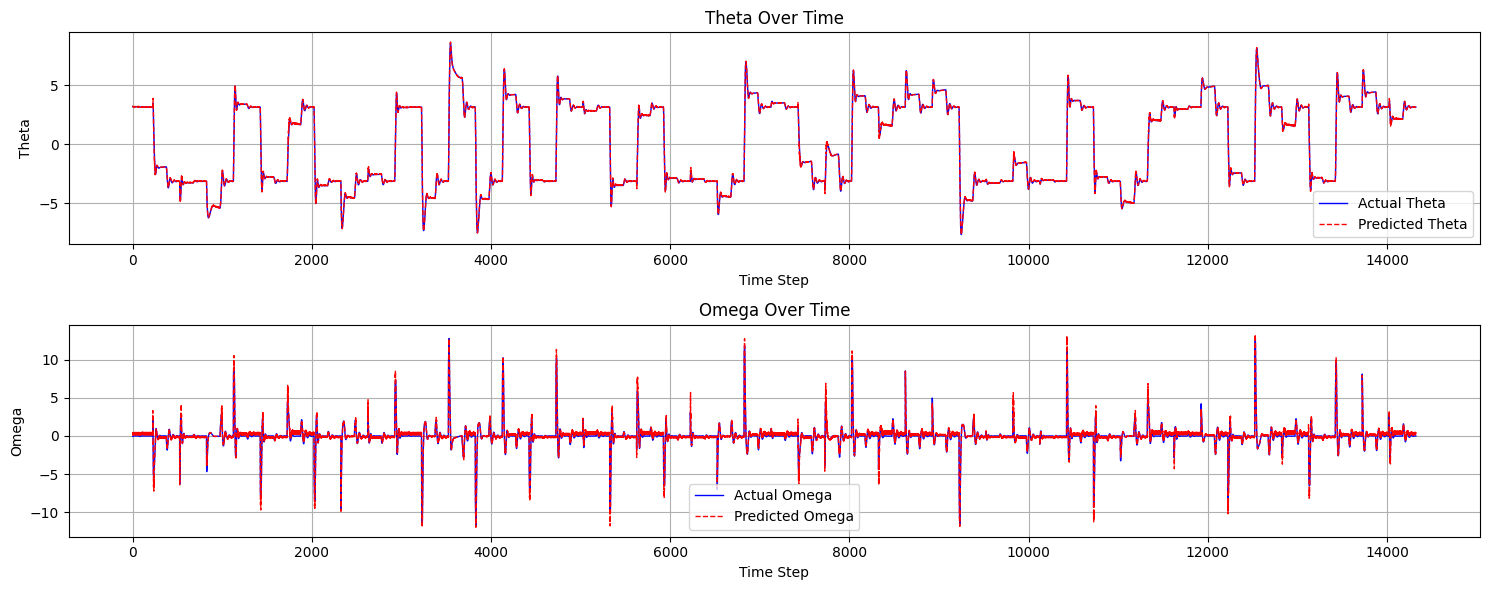

In [4]:
# Required Libraries and Modules
import pickle
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from torchdyn.models import NeuralODE
import matplotlib.pyplot as plt
import numpy as np


def load_data(theta_file_path, omega_file_path):
    with open(theta_file_path, 'rb') as f:
        theta = pickle.load(f)
    with open(omega_file_path, 'rb') as f:
        omega = pickle.load(f)
    return theta, omega

def prepare_continuous_dataset(theta, omega, train_size=800, val_size=100):

    # Convert the data to PyTorch tensors
    theta_tensor = torch.tensor(theta, dtype=torch.float32)
    omega_tensor = torch.tensor(omega, dtype=torch.float32)

    # Stack the theta and omega tensors to create the input tensor
    inputs = torch.stack((theta_tensor[:-1], omega_tensor[:-1]), dim=1)
    targets = torch.stack((theta_tensor[1:], omega_tensor[1:]), dim=1)

    # Split the dataset into training, validation, and test sets
    train_inputs = inputs[:train_size]
    train_targets = targets[:train_size]

    val_inputs = inputs[train_size:train_size + val_size]
    val_targets = targets[train_size:train_size + val_size]

    test_inputs = inputs[train_size + val_size:]
    test_targets = targets[train_size + val_size:]

    # Create DataLoader instances for the training, validation, and test sets
    train_loader = DataLoader(TensorDataset(train_inputs, train_targets), batch_size=16, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_inputs, val_targets), batch_size=16, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=4, shuffle=False)


    return train_loader, val_loader, test_loader

# Data path directory
file_path = '/kaggle/input/sazzatbhai/control_signal/'

theta_file_path = file_path + 'theta.pkl'
omega_file_path = file_path + 'omega.pkl'


# Load the data
theta, omega = load_data(theta_file_path, omega_file_path)

# Prepare the dataset
train_loader, val_loader, test_loader = prepare_continuous_dataset(theta, omega)
# Model Definition
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)


class PendulumModel(nn.Module):
    def __init__(self):
        super(PendulumModel, self).__init__()
        self.func = ODEFunc()
        self.neural_ode = NeuralODE(self.func, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4)

    def forward(self, x):
        t_span = torch.linspace(0, 1, 2)
        return self.neural_ode.trajectory(x, t_span)[-1]


class PendulumModelPL(pl.LightningModule):
    def __init__(self):
        super(PendulumModelPL, self).__init__()
        self.model = PendulumModel()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# Training and Evaluation
model = PendulumModelPL()
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model, train_loader, val_loader)

# Function to Plot Predictions for the Entire Test Set
def plot_predictions_for_test_set(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode

    predicted_states = []  # Accumulate predictions
    actual_states = []  # Accumulate actual states

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            num_steps = inputs.size(0)  # Number of time steps in the current batch

            current_state = inputs[0]
            for i in range(num_steps - 1):
                next_state = model(current_state).detach()
                predicted_states.append(next_state.squeeze().numpy())
                actual_states.append(targets[i].numpy())
                current_state = next_state

    predicted_states = np.array(predicted_states)
    actual_states = np.array(actual_states)

    plt.figure(figsize=(15, 6))

    # Plot for Theta
    plt.subplot(2, 1, 1)
    plt.plot(actual_states[:, 0], 'b-', label='Actual Theta', linewidth=1)
    plt.plot(predicted_states[:, 0], 'r--', label='Predicted Theta', linewidth=1)
    plt.title('Theta Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Theta')
    plt.legend()
    plt.grid(True)

    # Plot for Omega
    plt.subplot(2, 1, 2)
    plt.plot(actual_states[:, 1], 'b-', label='Actual Omega', linewidth=1)
    plt.plot(predicted_states[:, 1], 'r--', label='Predicted Omega', linewidth=1)
    plt.title('Omega Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    model.train()  # Revert the model back to training mode

# Plot Predictions for the Entire Test Set
plot_predictions_for_test_set(model, test_loader)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

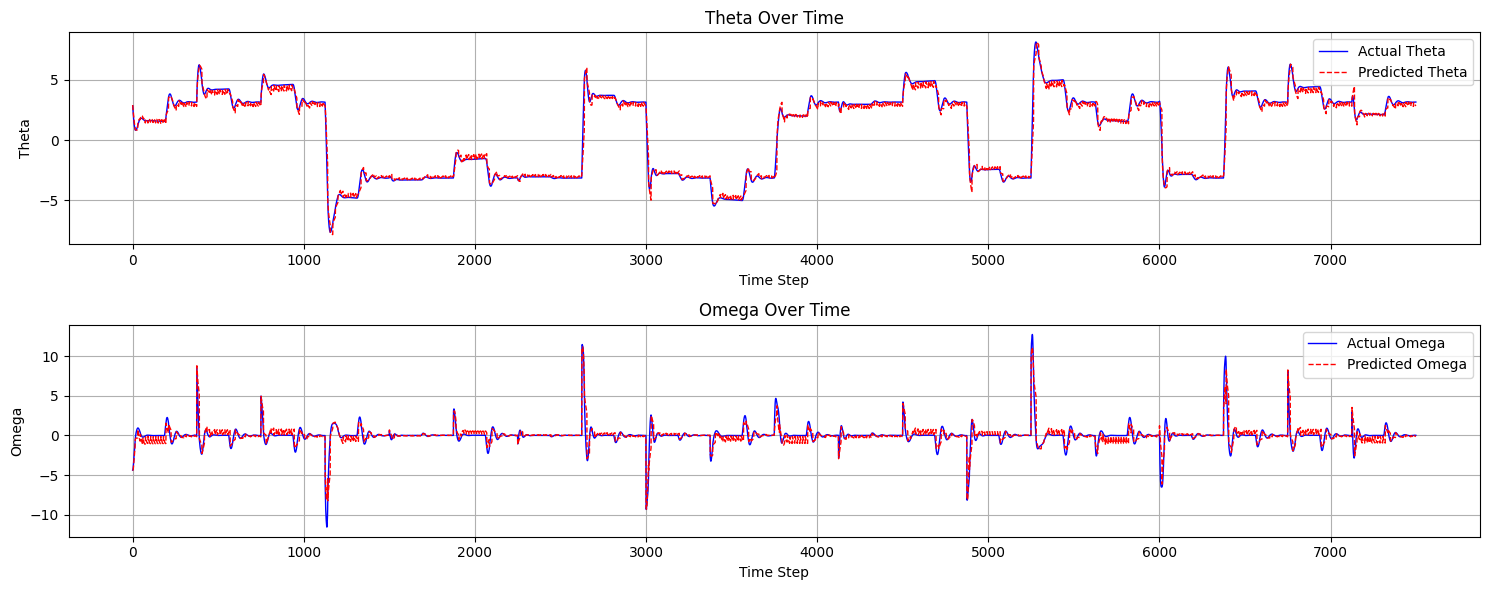

In [22]:
import pickle
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from torchdyn.models import NeuralODE
import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning.callbacks import EarlyStopping

def load_data(theta_file_path, omega_file_path, torque_file_path):
    with open(theta_file_path, 'rb') as f:
        theta = pickle.load(f)
    with open(omega_file_path, 'rb') as f:
        omega = pickle.load(f)
    with open(torque_file_path, 'rb') as f:
        torque = pickle.load(f)
    return theta, omega, torque

def prepare_continuous_dataset(theta, omega, torque, train_size=10000, val_size=2000):

    # Convert the data to PyTorch tensors
    theta_tensor = torch.tensor(theta, dtype=torch.float32)
    omega_tensor = torch.tensor(omega, dtype=torch.float32)
    torque_tensor = torch.tensor(torque, dtype=torch.float32)

    # Stack the theta, omega, and torque tensors to create the input tensor
    inputs = torch.stack((theta_tensor[:-1], omega_tensor[:-1], torque_tensor[:-1]), dim=1)
    targets = torch.stack((theta_tensor[1:], omega_tensor[1:], torque_tensor[1:]), dim=1)

    # Split the dataset into training, validation, and test sets
    train_inputs = inputs[:train_size]
    train_targets = targets[:train_size]

    val_inputs = inputs[train_size:train_size + val_size]
    val_targets = targets[train_size:train_size + val_size]

    test_inputs = inputs[train_size + val_size:]
    test_targets = targets[train_size + val_size:]

    # Create DataLoader instances for the training, validation, and test sets
    train_loader = DataLoader(TensorDataset(train_inputs, train_targets), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_inputs, val_targets), batch_size=32, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=16, shuffle=False)


    return train_loader, val_loader, test_loader

# Data path directory
file_path = '/kaggle/input/sazzatbhai/control_signal/'

theta_file_path = file_path + 'theta.pkl'
omega_file_path = file_path + 'omega.pkl'
torque_file_path = file_path + 'torque.pkl'


# Load the data
theta, omega, torque = load_data(theta_file_path, omega_file_path, torque_file_path)

# Prepare the dataset
train_loader, val_loader, test_loader = prepare_continuous_dataset(theta, omega, torque)

class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64), nn.Dropout(p=0.2), nn.Tanh(),
            nn.Linear(64, 128), nn.Dropout(p=0.2), nn.Tanh(),
            nn.Linear(128, 64), nn.Dropout(p=0.2), nn.Tanh(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.net(x)

class PendulumModel(nn.Module):
    def __init__(self):
        super(PendulumModel, self).__init__()
        self.func = ODEFunc()
        self.neural_ode = NeuralODE(self.func, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4)

    def forward(self, x):
        t_span = torch.linspace(0, 1, 2)
        return self.neural_ode.trajectory(x, t_span)[-1]

class PendulumModelPL(pl.LightningModule):
    def __init__(self):
        super(PendulumModelPL, self).__init__()
        self.model = PendulumModel()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def on_epoch_end(self):
        # Print training and validation loss at the end of each epoch
        train_loss = self.trainer.callback_metrics.get("train_loss")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        print(f'Epoch {self.current_epoch}: train_loss={train_loss}, val_loss={val_loss}')
# Incorporate Early Stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=3,
    verbose=True,
    mode='min'
)
# Training and Evaluation
model = PendulumModelPL()
trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[early_stop_callback],
)
trainer.fit(model, train_loader, val_loader)




# Function to Plot Predictions for the Entire Test Set
def plot_predictions_for_test_set(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode
    predicted_states = []  # Accumulate predictions
    actual_states = []  # Accumulate actual states

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            num_steps = inputs.size(0)  # Number of time steps in the current batch

            current_state = inputs[0]
            for i in range(num_steps - 1):
                next_state = model(current_state).detach()
                predicted_states.append(next_state.squeeze().numpy())
                actual_states.append(targets[i].numpy())
                current_state = next_state

    predicted_states = np.array(predicted_states)
    actual_states = np.array(actual_states)

    plt.figure(figsize=(15, 6))

    # Plot for Theta
    plt.subplot(2, 1, 1)
    plt.plot(actual_states[:, 0], 'b-', label='Actual Theta', linewidth=1)
    plt.plot(predicted_states[:, 0], 'r--', label='Predicted Theta', linewidth=1)
    plt.title('Theta Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Theta')
    plt.legend()
    plt.grid(True)

    # Plot for Omega
    plt.subplot(2, 1, 2)
    plt.plot(actual_states[:, 1], 'b-', label='Actual Omega', linewidth=1)
    plt.plot(predicted_states[:, 1], 'r--', label='Predicted Omega', linewidth=1)
    plt.title('Omega Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    model.train()  # Revert the model back to training mode

# Plot Predictions for the Entire Test Set
plot_predictions_for_test_set(model, test_loader)



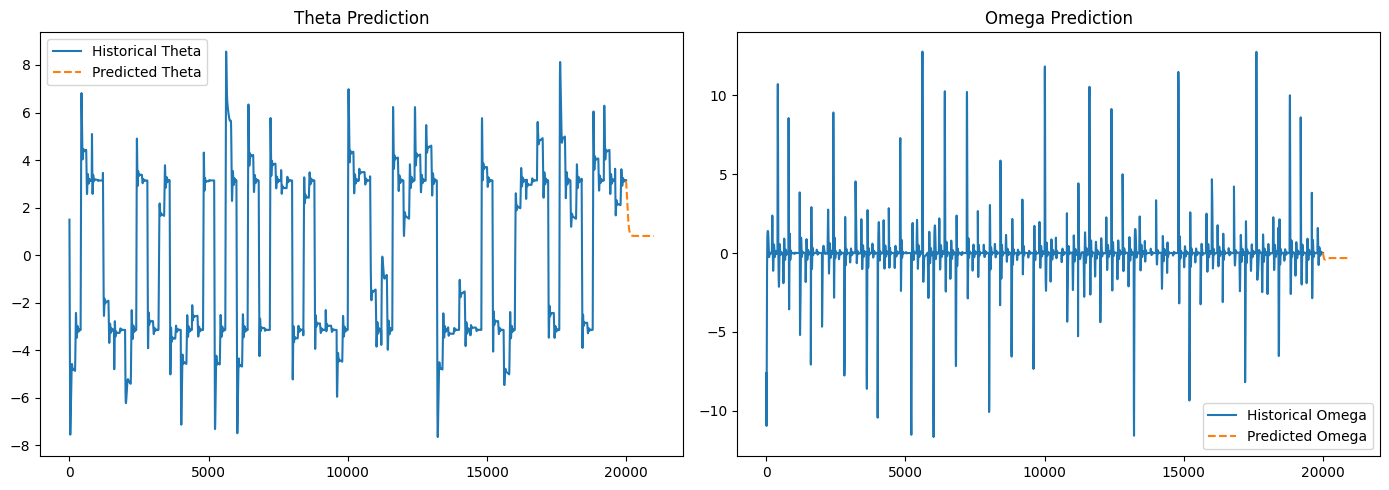

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle


def load_data(theta_file_path, omega_file_path, torque_file_path):
    with open(theta_file_path, 'rb') as f:
        theta = pickle.load(f)
    with open(omega_file_path, 'rb') as f:
        omega = pickle.load(f)
    with open(torque_file_path, 'rb') as f:
        torque = pickle.load(f)
    return theta, omega, torque

# Data path directory
file_path = '/kaggle/input/sazzatbhai/control_signal/'

theta_file_path = file_path + 'theta.pkl'
omega_file_path = file_path + 'omega.pkl'
torque_file_path = file_path + 'torque.pkl'


# Load the data
theta, omega, torque = load_data(theta_file_path, omega_file_path, torque_file_path)

# Prepare the last data point with a dummy torque if necessary
# Here we use the actual last torque value, but you can adjust as needed
last_data_point = torch.tensor([theta[-1], omega[-1], torque[-1]], dtype=torch.float).unsqueeze(0)  # [1, 3]

def predict_future_steps(model, initial_state, steps=1000):
    model.eval()
    predictions = []
    current_state = initial_state
    
    with torch.no_grad():
        for _ in range(steps):
            next_state = model(current_state)
            predictions.append(next_state.squeeze().numpy())
            current_state = next_state
            
    return np.array(predictions)

# Generate future predictions
predictions = predict_future_steps(model, last_data_point, steps=1000)

# Plot the historical and predicted values
plt.figure(figsize=(14, 5))

# Historical Theta
plt.subplot(1, 2, 1)
plt.plot(theta, label='Historical Theta')
plt.plot(np.arange(len(theta), len(theta) + len(predictions)), predictions[:, 0], label='Predicted Theta', linestyle='--')
plt.title('Theta Prediction')
plt.legend()

# Historical Omega
plt.subplot(1, 2, 2)
plt.plot(omega, label='Historical Omega')
plt.plot(np.arange(len(omega), len(omega) + len(predictions)), predictions[:, 1], label='Predicted Omega', linestyle='--')
plt.title('Omega Prediction')
plt.legend()

plt.tight_layout()
plt.show()


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

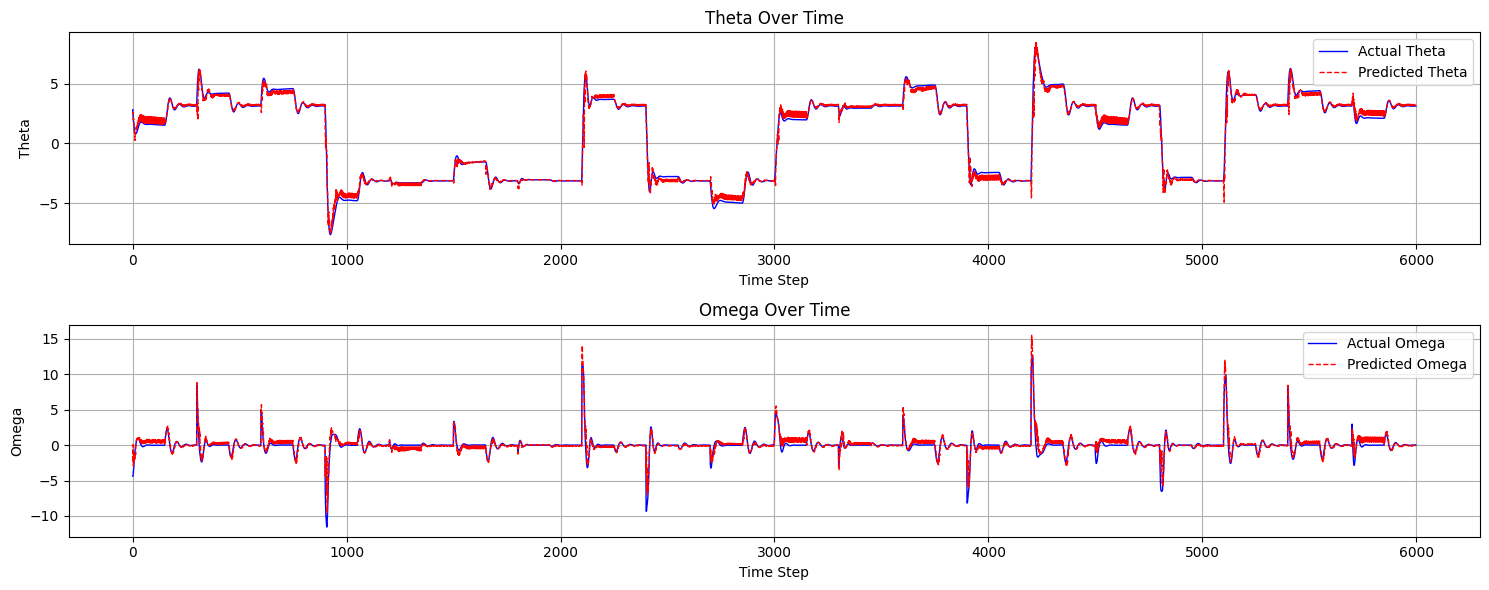

In [28]:
import pickle
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from torchdyn.models import NeuralODE
import matplotlib.pyplot as plt
import numpy as np


def load_data(theta_file_path, omega_file_path, torque_file_path):
    with open(theta_file_path, 'rb') as f:
        theta = pickle.load(f)
    with open(omega_file_path, 'rb') as f:
        omega = pickle.load(f)
    with open(torque_file_path, 'rb') as f:
        torque = pickle.load(f)
    return theta, omega, torque

def prepare_continuous_dataset(theta, omega, torque, train_size=10000, val_size=2000):

    # Convert the data to PyTorch tensors
    theta_tensor = torch.tensor(theta, dtype=torch.float32)
    omega_tensor = torch.tensor(omega, dtype=torch.float32)
    torque_tensor = torch.tensor(torque, dtype=torch.float32)

    # Stack the theta, omega, and torque tensors to create the input tensor
    inputs = torch.stack((theta_tensor[:-1], omega_tensor[:-1], torque_tensor[:-1]), dim=1)
    targets = torch.stack((theta_tensor[1:], omega_tensor[1:], torque_tensor[1:]), dim=1)

    # Split the dataset into training, validation, and test sets
    train_inputs = inputs[:train_size]
    train_targets = targets[:train_size]

    val_inputs = inputs[train_size:train_size + val_size]
    val_targets = targets[train_size:train_size + val_size]

    test_inputs = inputs[train_size + val_size:]
    test_targets = targets[train_size + val_size:]

    # Create DataLoader instances for the training, validation, and test sets
    train_loader = DataLoader(TensorDataset(train_inputs, train_targets), batch_size=16, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_inputs, val_targets), batch_size=16, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=4, shuffle=False)


    return train_loader, val_loader, test_loader

# Data path directory
file_path = '/kaggle/input/sazzatbhai/control_signal/'

theta_file_path = file_path + 'theta.pkl'
omega_file_path = file_path + 'omega.pkl'
torque_file_path = file_path + 'torque.pkl'


# Load the data
theta, omega, torque = load_data(theta_file_path, omega_file_path, torque_file_path)

# Prepare the dataset
train_loader, val_loader, test_loader = prepare_continuous_dataset(theta, omega, torque)

import torch
import torch.nn as nn

class MLPModel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=3):
        super(MLPModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)




import pytorch_lightning as pl

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

class PendulumMLPModelPL(pl.LightningModule):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=3):
        super(PendulumMLPModelPL, self).__init__()
        self.model = MLPModel(input_dim, hidden_dim, output_dim)
    
    def forward(self, x):
        # Forward pass through the model
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        # Training step
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Validation step
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    
    def configure_optimizers(self):
        # Configure the optimizer
        return torch.optim.Adam(self.parameters(), lr=0.001)
    
    def on_epoch_end(self):
        # Hook that is called at the end of each epoch
        avg_train_loss = torch.stack([x['loss'] for x in self.trainer.progress_bar_dict['train_loss']]).mean()
        avg_val_loss = torch.stack([x['loss'] for x in self.trainer.progress_bar_dict['val_loss']]).mean()
        print(f'\nEpoch {self.current_epoch} - avg_train_loss: {avg_train_loss:.4f}, avg_val_loss: {avg_val_loss:.4f}')

# Incorporate Early Stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=3,
    verbose=True,
    mode='min'
)
# Initialize the MLP model
model = PendulumMLPModelPL()

# Training and Evaluation with Early Stopping and Trainer setup remains unchanged
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[early_stop_callback],
)

trainer.fit(model, train_loader, val_loader)




# Function to Plot Predictions for the Entire Test Set
def plot_predictions_for_test_set(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode
    predicted_states = []  # Accumulate predictions
    actual_states = []  # Accumulate actual states

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            num_steps = inputs.size(0)  # Number of time steps in the current batch

            current_state = inputs[0]
            for i in range(num_steps - 1):
                next_state = model(current_state).detach()
                predicted_states.append(next_state.squeeze().numpy())
                actual_states.append(targets[i].numpy())
                current_state = next_state

    predicted_states = np.array(predicted_states)
    actual_states = np.array(actual_states)

    plt.figure(figsize=(15, 6))

    # Plot for Theta
    plt.subplot(2, 1, 1)
    plt.plot(actual_states[:, 0], 'b-', label='Actual Theta', linewidth=1)
    plt.plot(predicted_states[:, 0], 'r--', label='Predicted Theta', linewidth=1)
    plt.title('Theta Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Theta')
    plt.legend()
    plt.grid(True)

    # Plot for Omega
    plt.subplot(2, 1, 2)
    plt.plot(actual_states[:, 1], 'b-', label='Actual Omega', linewidth=1)
    plt.plot(predicted_states[:, 1], 'r--', label='Predicted Omega', linewidth=1)
    plt.title('Omega Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    model.train()  # Revert the model back to training mode

# Plot Predictions for the Entire Test Set
plot_predictions_for_test_set(model, test_loader)

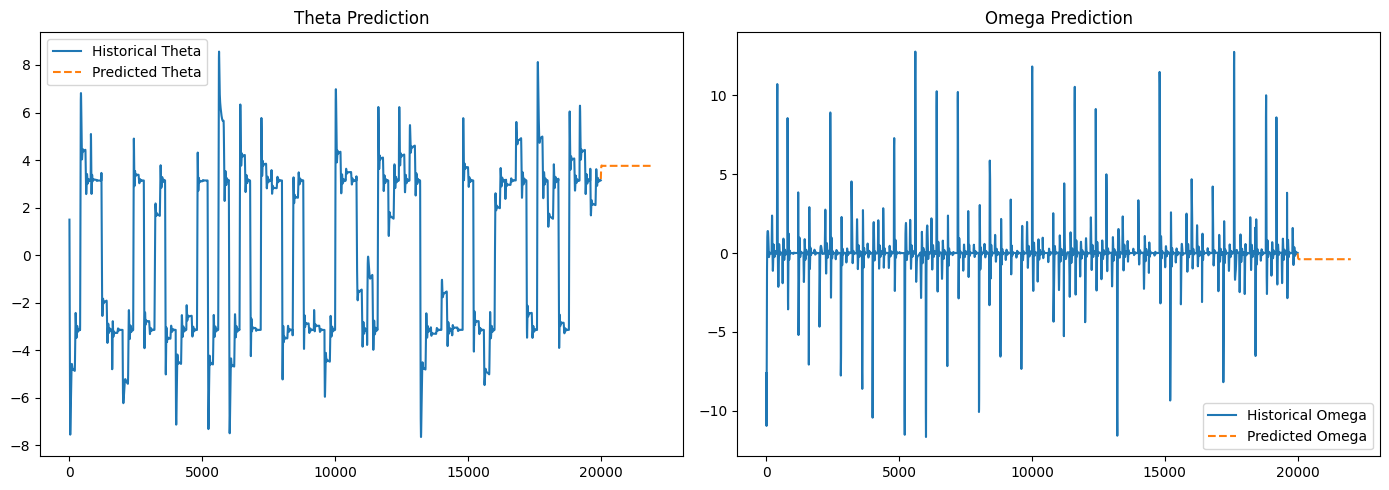

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle


def load_data(theta_file_path, omega_file_path, torque_file_path):
    with open(theta_file_path, 'rb') as f:
        theta = pickle.load(f)
    with open(omega_file_path, 'rb') as f:
        omega = pickle.load(f)
    with open(torque_file_path, 'rb') as f:
        torque = pickle.load(f)
    return theta, omega, torque

# Data path directory
file_path = '/kaggle/input/sazzatbhai/control_signal/'

theta_file_path = file_path + 'theta.pkl'
omega_file_path = file_path + 'omega.pkl'
torque_file_path = file_path + 'torque.pkl'


# Load the data
theta, omega, torque = load_data(theta_file_path, omega_file_path, torque_file_path)

# Prepare the last data point with a dummy torque if necessary
# Here we use the actual last torque value, but you can adjust as needed
last_data_point = torch.tensor([theta[-1], omega[-1], torque[-1]], dtype=torch.float).unsqueeze(0)  # [1, 3]

def predict_future_steps(model, initial_state, steps=2000):
    model.eval()
    predictions = []
    current_state = initial_state
    
    with torch.no_grad():
        for _ in range(steps):
            next_state = model(current_state)
            predictions.append(next_state.squeeze().numpy())
            current_state = next_state
            
    return np.array(predictions)

# Generate future predictions
predictions = predict_future_steps(model, last_data_point, steps=2000)

# Plot the historical and predicted values
plt.figure(figsize=(14, 5))

# Historical Theta
plt.subplot(1, 2, 1)
plt.plot(theta, label='Historical Theta')
plt.plot(np.arange(len(theta), len(theta) + len(predictions)), predictions[:, 0], label='Predicted Theta', linestyle='--')
plt.title('Theta Prediction')
plt.legend()

# Historical Omega
plt.subplot(1, 2, 2)
plt.plot(omega, label='Historical Omega')
plt.plot(np.arange(len(omega), len(omega) + len(predictions)), predictions[:, 1], label='Predicted Omega', linestyle='--')
plt.title('Omega Prediction')
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
!pip install torchdyn


  Obtaining dependency information for torchdyn from https://files.pythonhosted.org/packages/a6/81/14535d528bf27cacb0fde2bb6893c9b852e17ae232f743cab99807f28ee4/torchdyn-1.0.6-py3-none-any.whl.metadata
  Obtaining dependency information for torchsde from https://files.pythonhosted.org/packages/dd/1f/b67ebd7e19ffe259f05d3cf4547326725c3113d640c277030be3e9998d6f/torchsde-0.2.6-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.0 MB/s eta 0:00:00


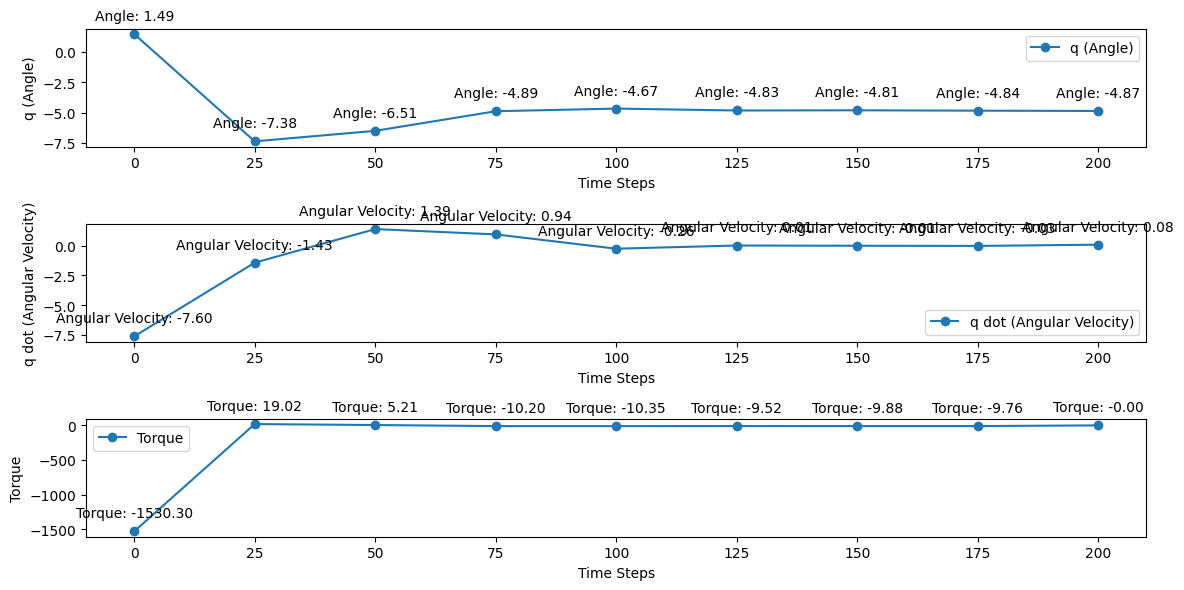

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp1d
import matplotlib.animation as animation

# Load data from the pickle files
file_path = '/kaggle/input/sazzatbhai/control_signal/'
with open(file_path + 'theta.pkl', 'rb') as f:
    theta = pickle.load(f)
with open(file_path + 'omega.pkl', 'rb') as f:
    omega = pickle.load(f)
with open(file_path + 'torque.pkl', 'rb') as f:
    torque = pickle.load(f)

# Create a list of time steps
time_steps = list(range(len(theta)))

# Define the time intervals you want to simulate and plot for the first 200 time steps
time_intervals = list(range(0, 201, 25))  # Simulate every 25 time steps within the first 200 time steps

# Ensure that the time intervals are within the available data range
max_index = min(len(theta), len(omega), len(torque))
time_intervals = [t for t in time_intervals if t <= max_index]

# Interpolate data to simulate gradual changes
interpolated_alpha = interp1d(range(max_index), theta[:max_index], kind='cubic')
interpolated_omega = interp1d(range(max_index), omega[:max_index], kind='cubic')
interpolated_torque = interp1d(range(max_index), torque[:max_index], kind='cubic')

# Generate simulated data at specified time intervals
simulated_alpha = interpolated_alpha(time_intervals)
simulated_omega = interpolated_omega(time_intervals)
simulated_torque = interpolated_torque(time_intervals)

# Plot the simulated data with annotations
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)  # Subplot for q (theta)
plt.plot(time_intervals, simulated_alpha, marker='o', linestyle='-', markersize=6, label='q (Angle)')
plt.xlabel('Time Steps')
plt.ylabel('q (Angle)')
plt.legend()

# Annotate data points with angle values
for i, angle_value in enumerate(simulated_alpha):
    plt.annotate(f'Angle: {angle_value:.2f}', (time_intervals[i], angle_value), textcoords="offset points", xytext=(0, 10), ha='center')

plt.subplot(3, 1, 2)  # Subplot for q dot (omega)
plt.plot(time_intervals, simulated_omega, marker='o', linestyle='-', markersize=6, label='q dot (Angular Velocity)')
plt.xlabel('Time Steps')
plt.ylabel('q dot (Angular Velocity)')
plt.legend()

# Annotate data points with angular velocity values
for i, omega_value in enumerate(simulated_omega):
    plt.annotate(f'Angular Velocity: {omega_value:.2f}', (time_intervals[i], omega_value), textcoords="offset points", xytext=(0, 10), ha='center')

plt.subplot(3, 1, 3)  # Subplot for torque
plt.plot(time_intervals, simulated_torque, marker='o', linestyle='-', markersize=6, label='Torque')
plt.xlabel('Time Steps')
plt.ylabel('Torque')
plt.legend()

# Annotate data points with torque values
for i, torque_value in enumerate(simulated_torque):
    plt.annotate(f'Torque: {torque_value:.2f}', (time_intervals[i], torque_value), textcoords="offset points", xytext=(0, 10), ha='center')

plt.tight_layout()
plt.show()

In [5]:
import pickle
import torch

def load_data(file_name):
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    # Convert data to PyTorch tensor
    return torch.tensor(data, dtype=torch.float32)

saz1 = load_data('/kaggle/input/sazzatbhai/control_signal/target_velocity.pkl')
saz2 = load_data('/kaggle/input/sazzatbhai/control_signal/target_angle.pkl')
saz3 = load_data('/kaggle/input/sazzatbhai/control_signal/torque.pkl')
# Check if the tensors are at least 2-dimensional
print(saz1.shape)
print(saz2.shape)
print(saz3.shape)

# If they are not, and assuming they are 1D, you could add a dimension like this:
saz1 = saz1.unsqueeze(1)
saz2 = saz2.unsqueeze(1)
saz3 = saz3.unsqueeze(1)

# Now you should be able to concatenate along dimension 1
combined_input = torch.cat((saz1, saz2, saz3), dim=1)


torch.Size([20000])
torch.Size([20000])
torch.Size([20000])


In [3]:
pip install torch torchdiffeq matplotlib numpy pandas


Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch.nn as nn
from torchdiffeq import odeint

class ODEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODE(nn.Module):
    def __init__(self, ode_func):
        super(NeuralODE, self).__init__()
        self.ode_func = ode_func

    def forward(self, t, y0):
        return odeint(self.ode_func, y0, t, method='dopri5')

In [12]:
# Set dimensions
input_dim = combined_input.shape[1]  # Adjust according to your input data
hidden_dim = 50  # Example size, you can change it
output_dim = 2  # As you want 2 outputs

# Initialize the model
ode_func = ODEFunc(input_dim, hidden_dim, output_dim)
model = NeuralODE(ode_func)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Set learning rate
loss_func = nn.MSELoss()  # Example loss function, you can change it



In [6]:
import torch
import torch.nn as nn
import pickle
from torchdiffeq import odeint_adjoint as odeint

# Load the Data
def load_data(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    return data



# Preprocess the Data
saz1_tensor = torch.tensor(saz1, dtype=torch.float32).clone().detach()
saz2_tensor = torch.tensor(saz2, dtype=torch.float32).clone().detach()
saz3_tensor = torch.tensor(saz3, dtype=torch.float32).clone().detach()

# Concatenate data for model input
input_tensor = torch.cat((saz1_tensor, saz2_tensor, saz3_tensor), dim=1)

# Check the input tensor shape
print(f'Input tensor shape: {input_tensor.shape}')

# Define the Neural ODE Model
class ODEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, t, y):
        return self.net(y)

# Adjust these dimensions as per your dataset
input_dim = input_tensor.shape[1]
hidden_dim = 50
output_dim = input_dim

func = ODEFunc(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)

# Train the Model
for epoch in range(50):  # Adjust the number of epochs as needed
    optimizer.zero_grad()
    t = torch.tensor([0, 1], dtype=torch.float32)
    pred_y = odeint(func, input_tensor, t)
    loss = torch.mean(torch.abs(pred_y - input_tensor))  # Define your loss function
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: loss = {loss.item()}')

# Make Predictions
pred_y = odeint(func, input_tensor, t)
saz1_output, saz2_output = pred_y[1, :, 0], pred_y[1, :, 1]  # Extract the output for saz1 and saz2

# Output shapes
print(f'saz1_output shape: {saz1_output.shape}')
print(f'saz2_output shape: {saz2_output.shape}')

# Further processing as needed...


/tmp/ipykernel_537/4088753005.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  saz1_tensor = torch.tensor(saz1, dtype=torch.float32).clone().detach()
/tmp/ipykernel_537/4088753005.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  saz2_tensor = torch.tensor(saz2, dtype=torch.float32).clone().detach()
/tmp/ipykernel_537/4088753005.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  saz3_tensor = torch.tensor(saz3, dtype=torch.float32).clone().detach()


Input tensor shape: torch.Size([20000, 3])
Epoch 0: loss = 0.30476272106170654
Epoch 10: loss = 0.1742723137140274
Epoch 20: loss = 0.09763824939727783
Epoch 30: loss = 0.05248206853866577
Epoch 40: loss = 0.03348630294203758
saz1_output shape: torch.Size([20000])
saz2_output shape: torch.Size([20000])


Epoch 0: loss = 0.1757146418094635
Epoch 10: loss = 0.07928141206502914
Epoch 20: loss = 0.04466894268989563
Epoch 30: loss = 0.03589574247598648
Epoch 40: loss = 0.024958733469247818


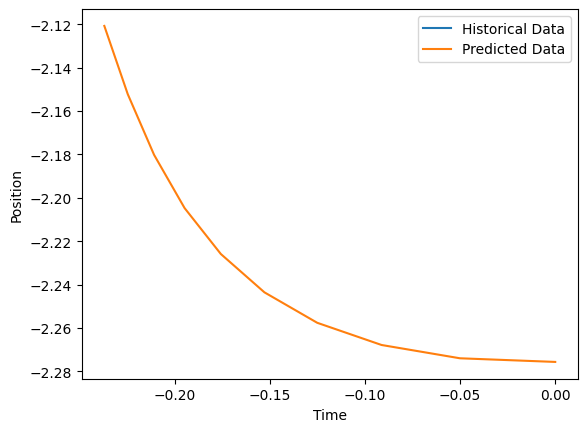

In [11]:
import torch
import torch.nn as nn
import torchdiffeq

class ODEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, t, y):
        return self.net(y)

# Adjust these dimensions as per your dataset
input_dim = input_tensor.shape[1]
hidden_dim = 50
output_dim = input_dim

func = ODEFunc(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)

# Train the model
for epoch in range(50):
    optimizer.zero_grad()
    t = torch.tensor([0, 1], dtype=torch.float32)
    pred_y = torchdiffeq.odeint_adjoint(func, input_tensor, t)
    loss = torch.mean(torch.abs(pred_y - input_tensor))
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}: loss = {loss.item()}')
# Get the last positional data of the pendulum
last_data = input_tensor[-1, :]

# Predict the next 10 future positions
t = torch.linspace(1, 11, 10)
pred_y = torchdiffeq.odeint_adjoint(func, last_data.unsqueeze(0), t)

# Extract the predicted velocity and angle data
pred_velocity = pred_y[:, :, 0]
pred_angle = pred_y[:, :, 1]
import matplotlib.pyplot as plt

# Plot the historical data
plt.plot(input_tensor[-10:, 0], input_tensor[-10:, 1], label="Historical Data")

# Plot the predicted data
plt.plot(pred_velocity.detach().numpy(), pred_angle.detach().numpy(), label="Predicted Data")

plt.xlabel("Time")
plt.ylabel("Position")
plt.legend()
plt.show()

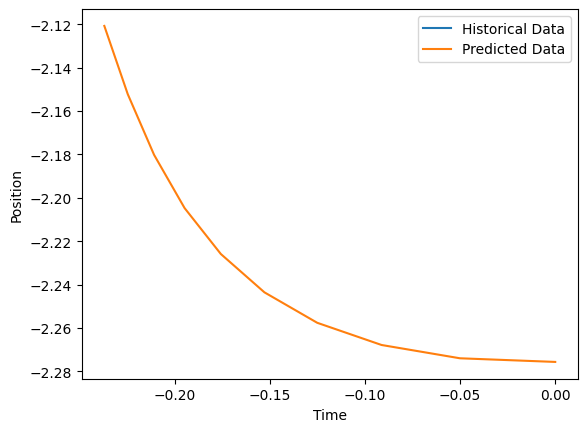

In [18]:
# Predict the next 10 future positions
t = torch.linspace(1, 11, 10)
pred_y = torchdiffeq.odeint_adjoint(func, last_data.unsqueeze(0), t)

# Extract the predicted velocity and angle data
pred_velocity = pred_y[:, :, 0]
pred_angle = pred_y[:, :, 1]
import matplotlib.pyplot as plt

# Plot the historical data
plt.plot(input_tensor[-10:, 0], input_tensor[-10:, 1], label="Historical Data")

# Plot the predicted data
plt.plot(pred_velocity.detach().numpy(), pred_angle.detach().numpy(), label="Predicted Data")

plt.xlabel("Time")
plt.ylabel("Position")
plt.legend()
plt.show()

In [9]:
# Define the time points for prediction (extend beyond the training time points)
future_steps = 5
t_future = torch.linspace(0, 1 + future_steps, steps=2 + future_steps)

# Use the trained model to predict the future
with torch.no_grad():  # We don't need to track gradients here
    future_pred = odeint(func, input_tensor, t_future)


In [11]:
import matplotlib.pyplot as plt

# Assuming saz1 and saz2 are the dimensions you want to plot
saz1_real = input_tensor[:, 0].numpy()  # Convert to numpy array for plotting
saz2_real = input_tensor[:, 1].numpy()

saz1_pred = future_pred[:, :, 0].numpy()  # Predictions
saz2_pred = future_pred[:, :, 1].numpy()

# Time points (assuming equal spacing and starting from 0)
time_points_real = torch.linspace(0, 1, steps=input_tensor.shape[0]).numpy()
time_points_future = t_future.numpy()




In [12]:
print("Shapes:", time_points_real.shape, saz1_real.shape, saz2_real.shape, time_points_future.shape, saz1_pred.shape, saz2_pred.shape)


Shapes: (20000,) (20000,) (20000,) (7,) (7, 20000) (7, 20000)


In [13]:
# Animation function
def animate(i):
    # Update real data lines
    lines[0].set_data(time_points_real[:i], saz1_real[:i])
    lines[1].set_data(time_points_real[:i], saz2_real[:i])

    # Update predicted data lines
    # Make sure the indexing is correct and the lengths match
    lines[2].set_data(time_points_future[:i], saz1_pred[:i])
    lines[3].set_data(time_points_future[:i], saz2_pred[:i])
    
    return lines


In [41]:
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def load_data(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    return data
saz1 = load_data('/kaggle/input/sazzatbhai/control_signal/target_velocity.pkl')
saz2 = load_data('/kaggle/input/sazzatbhai/control_signal/target_angle.pkl')
saz3 = load_data('/kaggle/input/sazzatbhai/control_signal/torque.pkl')
# Preprocess the Data
saz1_tensor = torch.tensor(saz1, dtype=torch.float32).clone().detach()
saz2_tensor = torch.tensor(saz2, dtype=torch.float32).clone().detach()
saz3_tensor = torch.tensor(saz3, dtype=torch.float32).clone().detach()

# Reshape the tensors to add a new dimension
saz1_tensor = saz1_tensor.unsqueeze(1)
saz2_tensor = saz2_tensor.unsqueeze(1)
saz3_tensor = saz3_tensor.unsqueeze(1)

# Concatenate data for model input
input_tensor = torch.cat((saz1_tensor, saz2_tensor, saz3_tensor), dim=1)

# Check the input tensor shape
print(f'Input tensor shape: {input_tensor.shape}')

# Define the Neural ODE Model
class ODEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, t, y):
        return self.net(y)

# Adjust these dimensions as per your dataset
input_dim = input_tensor.shape[1]
hidden_dim = 50
output_dim = input_dim

func = ODEFunc(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)

# Train the Model
for epoch in range(1000):  # Adjust the number of epochs as needed
    optimizer.zero_grad()
    t = torch.tensor([0, 1], dtype=torch.float32)
    pred_y = odeint(func, input_tensor, t)
    loss = torch.mean(torch.abs(pred_y - input_tensor))  # Define your loss function
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: loss = {loss.item()}')

# Make Predictions
pred_y = odeint(func, input_tensor, t)
saz1_output, saz2_output = pred_y[1, :, 0], pred_y[1, :, 1]  # Extract the output for saz1 and saz2


# Get the last positional data of the pendulum
last_data = input_tensor[-1, :]


# Extract the predicted velocity and angle data
pred_velocity = pred_y[:, :, 0]
pred_angle = pred_y[:, :, 1]

# Print the predicted and actual positions
print("Predicted Positions:")
print(pred_velocity.detach().numpy()[-1], pred_angle.detach().numpy()[-1])
print("Actual Positions:")
print(saz1[-1], saz2[-1])



# Calculate the mean absolute error (MAE) as a performance metric
mae = torch.mean(torch.abs(pred_y - input_tensor))
print(f"Mean Absolute Error: {mae.item()}")


Input tensor shape: torch.Size([20000, 3])
Epoch 0: loss = 0.17233286798000336
Epoch 100: loss = 0.009947328828275204
Epoch 200: loss = 0.002974302740767598
Epoch 300: loss = 0.002042829291895032
Epoch 400: loss = 0.0017739712493494153
Epoch 500: loss = 0.0013849629322066903
Epoch 600: loss = 0.0015055190306156874
Epoch 700: loss = 0.0010141553357243538
Epoch 800: loss = 0.001240879064425826
Epoch 900: loss = 0.0012670407304540277
Predicted Positions:
[-0.00588867 -0.01516849 -0.01519707 ...  0.0024017   0.0024017
  0.0024017 ] [-5.717203  -5.712365  -5.7123227 ... -2.273232  -2.273232  -2.273232 ]
Actual Positions:
0 -2.275679086471473
Mean Absolute Error: 0.0011552219511941075


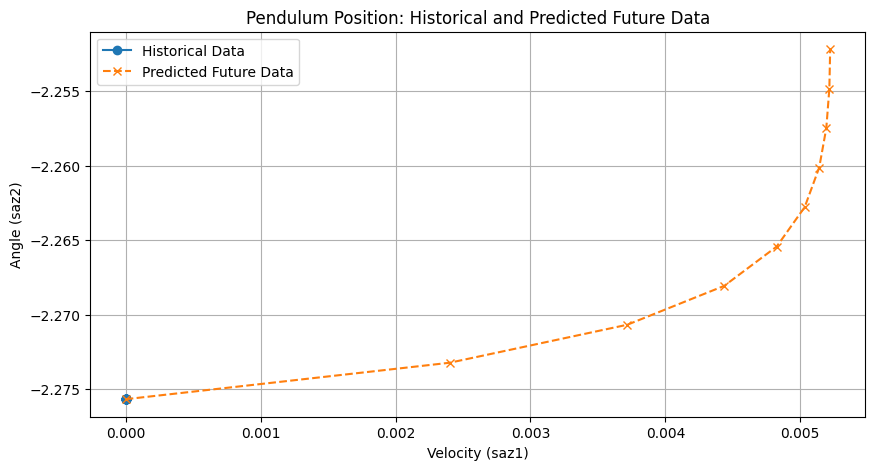

In [45]:
import torch
from torchdiffeq import odeint_adjoint as odeint

# ... (your code for loading data, defining ODEFunc, and training the model)

# Prediction
with torch.no_grad():
    future_time_points = torch.linspace(2, 11, 10)  # future time points (after the last training point, which is 1)
    last_data_point = input_tensor[-1]  # last data point as the initial condition
    future_pred = odeint(func, last_data_point, future_time_points)

# Get future predictions for velocity and angle
future_velocity = future_pred[:, 0]
future_angle = future_pred[:, 1]

# Visualize the last 20 historical data and the next 10 predictions
historical_time_points = torch.linspace(-19, 0, 20)  # last 20 historical time points
plt.figure(figsize=(10, 5))

# Historical data
plt.plot(saz1[-20:], saz2[-20:], 'o-', label='Historical Data')

# Future predictions
plt.plot(future_velocity.numpy(), future_angle.numpy(), 'x--', label='Predicted Future Data')

plt.xlabel('Velocity (saz1)')
plt.ylabel('Angle (saz2)')
plt.title('Pendulum Position: Historical and Predicted Future Data')
plt.legend()
plt.grid(True)
plt.show()


Input tensor shape: torch.Size([20000, 3])
Epoch 0: loss = 2.5204806327819824
Epoch 10: loss = 2.2250375747680664
Epoch 20: loss = 1.9430434703826904
Epoch 30: loss = 1.5904839038848877
Epoch 40: loss = 1.1435883045196533
